# BCS Workshop 2020
# Reinforcement Learning

__Adapted by:__ Debaditya Bhattacharya from NMA Summer School 2020.   

## Note

This notebook has been divided into 4 parts, and each part has sections, subsections, videos, demos and / or exercises under it. The contents of the notebook are _inherently_ difficult. Watch the videos, and rewatch them if you have to. Google things you don't understand. Seek simple explanations. Take your time while solving the questions. If you feel frustrated or stuck for long, take a break and come back to it a little bit later. Still stuck? Ask a friend or the workshop organizers. 

The solutions for the code has been embedded in the notebook. You should refrain from looking at them. Only do so when you are confident about your understanding, and your code is probably wobbly. It might seem tempting to peek at a solution and go "Ah yes that was obvious", and move on, but that will hamper your understanding and learning which is the primary focus.

Now without further ado, lets get started :)

All the best!

P.S. Don't forget to copy it to your own drive before you begin!

---
# Part 1
## Objectives
  
In this part, we will learn how to estimate state-value functions in a classical conditioning paradigm using Temporal Difference (TD) learning and examine TD-errors at the presentation of the conditioned and unconditioned stimulus (CS and US) under different CS-US contingencies. These exercises will provide you with an understanding of both how reward prediction errors (RPEs) behave in classical conditioning and what we should expect to see if Dopamine represents a "canonical" model-free RPE. 

At the end of this part:    
* You will learn to use the standard tapped delay line conditioning model
* You will understand how RPEs move to CS
* You will understand how variability in reward size effects RPEs
* You will understand how differences in US-CS timing effect RPEs

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# @title Helper functions
from matplotlib import ticker

def plot_value_function(V, ax=None, show=True):
  """Plot V(s), the value function"""
  if not ax:
    fig, ax = plt.subplots()

  ax.stem(V, use_line_collection=True)
  ax.set_ylabel('Value')
  ax.set_xlabel('State')
  ax.set_title("Value function: $V(s)$")

  if show:
    plt.show()

def plot_tde_trace(TDE, ax=None, show=True, skip=400):
  """Plot the TD Error across trials"""
  if not ax:
    fig, ax = plt.subplots()

  indx = np.arange(0, TDE.shape[1], skip)
  im = ax.imshow(TDE[:,indx])
  positions = ax.get_xticks()
  # Avoid warning when setting string tick labels
  ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
  ax.set_xticklabels([f"{int(skip * x)}" for x in positions])
  ax.set_title('TD-error over learning')
  ax.set_ylabel('State')
  ax.set_xlabel('Iterations')
  ax.figure.colorbar(im)
  if show:
    plt.show()

def learning_summary_plot(V, TDE):
  """Summary plot for Ex1"""
  fig, (ax1, ax2) = plt.subplots(nrows = 2, gridspec_kw={'height_ratios': [1, 2]})

  plot_value_function(V, ax=ax1, show=False)
  plot_tde_trace(TDE, ax=ax2, show=False)
  plt.tight_layout()

def reward_guesser_title_hint(r1, r2):
  """"Provide a mildly obfuscated hint for a demo."""
  if (r1==14 and r2==6) or (r1==6 and r2==14):
    return "Technically correct...(the best kind of correct)"

  if  ~(~(r1+r2) ^ 11) - 1 == (6 | 24): # Don't spoil the fun :-)
    return "Congratulations! You solved it!"

  return "Keep trying...."

#@title Default title text
class ClassicalConditioning:

    def __init__(self, n_steps, reward_magnitude, reward_time):

        # Task variables
        self.n_steps = n_steps
        self.n_actions = 0
        self.cs_time = int(n_steps/4) - 1

        # Reward variables
        self.reward_state = [0,0]
        self.reward_magnitude = None
        self.reward_probability = None
        self.reward_time = None

        self.set_reward(reward_magnitude, reward_time)

        # Time step at which the conditioned stimulus is presented

        # Create a state dictionary
        self._create_state_dictionary()

    def set_reward(self, reward_magnitude, reward_time):

        """
        Determine reward state and magnitude of reward
        """
        if reward_time >= self.n_steps - self.cs_time:
            self.reward_magnitude = 0

        else:
            self.reward_magnitude = reward_magnitude
            self.reward_state = [1, reward_time]

    def get_outcome(self, current_state):

        """
        Determine next state and reward
        """
        # Update state
        if current_state < self.n_steps - 1:
            next_state = current_state + 1
        else:
            next_state = 0

        # Check for reward
        if self.reward_state == self.state_dict[current_state]:
            reward = self.reward_magnitude
        else:
            reward = 0

        return next_state, reward

    def _create_state_dictionary(self):

        """
        This dictionary maps number of time steps/ state identities
        in each episode to some useful state attributes:

        state      - 0 1 2 3 4 5 (cs) 6 7 8 9 10 11 12 ...
        is_delay   - 0 0 0 0 0 0 (cs) 1 1 1 1  1  1  1 ...
        t_in_delay - 0 0 0 0 0 0 (cs) 1 2 3 4  5  6  7 ...
        """
        d = 0

        self.state_dict = {}
        for s in range(self.n_steps):
            if s <= self.cs_time:
                self.state_dict[s] = [0,0]
            else:
                d += 1 # Time in delay
                self.state_dict[s] = [1,d]

class MultiRewardCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that one randomly selected reward,
    magnitude, from a list, is delivered of a single fixed reward."""
  def __init__(self, n_steps, reward_magnitudes, reward_time=None):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: LIST of possible reward magnitudes.
        - reward_time: Single fixed reward time
      Uses numpy global random state.
      """
    super().__init__(n_steps, 1, reward_time)
    self.reward_magnitudes = reward_magnitudes

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward=np.random.choice(self.reward_magnitudes)
    return next_state, reward


class ProbabilisticCC(ClassicalConditioning):
  """Classical conditioning paradigm, except that rewards are stochastically omitted."""
  def __init__(self, n_steps, reward_magnitude, reward_time=None, p_reward=0.75):
    """"Build a multi-reward classical conditioning environment
      Args:
        - nsteps: Maximum number of steps
        - reward_magnitudes: Reward magnitudes.
        - reward_time: Single fixed reward time.
        - p_reward: probability that reward is actually delivered in rewarding state
      Uses numpy global random state.
      """
    super().__init__(n_steps, reward_magnitude, reward_time)
    self.p_reward = p_reward

  def get_outcome(self, current_state):
    next_state, reward = super().get_outcome(current_state)
    if reward:
      reward*= int(np.random.uniform(size=1)[0] < self.p_reward)
    return next_state, reward

---
## Section 1: TD-learning

Video available at https://youtu.be/YoNbc9M92YY


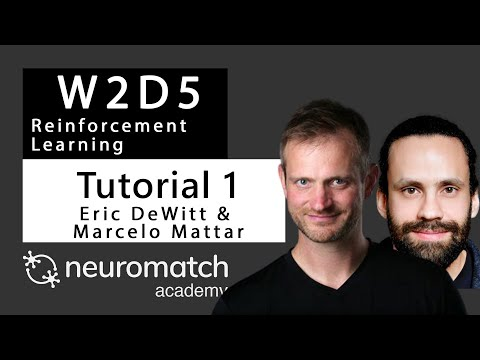

In [ ]:
#@title Video 1: Introduction
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="YoNbc9M92YY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

__Environment:__

- The agent experiences the environment in episodes or trials. 
- Episodes terminate by transitioning to the inter-trial-interval (ITI) state and they are initiated from the ITI state as well. We clamp the value of the terminal/ITI states to zero. 
- The classical conditioning environment is composed of a sequence of states that the agent deterministically transitions through. Starting at State 0, the agent moves to State 1 in the first step, from State 1 to State 2 in the second, and so on.  These states represent time in the tapped delay line representation
- Within each episode, the agent is presented a CS and US (reward). 
- The CS is always presented at 1/4 of the total duration of the trial. The US (reward) is then delivered after the CS. The interval between the CS and US is specified by `reward_time`.
- The agent's goal is to learn to predict expected rewards from each state in the trial. 


**General concepts**

* Return $G_{t}$: future cumulative reward, which can be written in arecursive form
\begin{align}
G_{t} &= \sum \limits_{k = 0}^{\infty} \gamma^{k} r_{t+k+1} \\
&= r_{t+1} + \gamma G_{t+1}
\end{align}
where $\gamma$ is discount factor that controls the importance of future rewards, and $\gamma \in [0, 1]$. $\gamma$ may also be interpreted as probability of continuing the trajectory.
* Value funtion $V_{\pi}(s_t=s)$: expecation of the return
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ G_{t}\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
& = \mathbb{E} [ r_{t+1} + \gamma G_{t+1}\; | \; s_t=s, a_{t:\infty}\sim\pi]
\end{align}
With an assumption of **Markov process**, we thus have:
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ r_{t+1} + \gamma V_{\pi}(s_{t+1})\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
&= \sum_a \pi(a|s) \sum_{r, s'}p(s', r)(r + V_{\pi}(s_{t+1}=s'))
\end{align}

**Temporal difference (TD) learning**

* With a Markovian assumption, we can use $V(s_{t+1})$ as an imperfect proxy for the true value $G_{t+1}$ (Monte Carlo bootstrapping), and thus obtain the generalised equation to calculate TD-error:
\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

* Value updated by using the learning rate constant $\alpha$:
\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}

  (Reference: https://web.stanford.edu/group/pdplab/pdphandbook/handbookch10.html)



__Definitions:__

* TD-error:
\begin{align}
\delta_{t} = r_{t+1} + \gamma V(s_{t+1}) - V(s_{t})
\end{align}

* Value updates:
\begin{align}
V(s_{t}) \leftarrow V(s_{t}) + \alpha \delta_{t}
\end{align}


### Exercise 1: TD-learning with guaranteed rewards
   
Implement TD-learning to estimate the state-value function in the classical-conditioning world with guaranteed rewards, with a fixed magnitude, at a fixed delay after the conditioned stimulus, CS. Save TD-errors over learning (i.e., over trials) so we can visualize them afterwards. 

In order to simulate the effect of the CS, you should only update $V(s_{t})$ during the delay period after CS. This period is indicated by the boolean variable `is_delay`. This can be implemented by multiplying the expression for updating the value function by `is_delay`.

Use the provided code to estimate the value function.

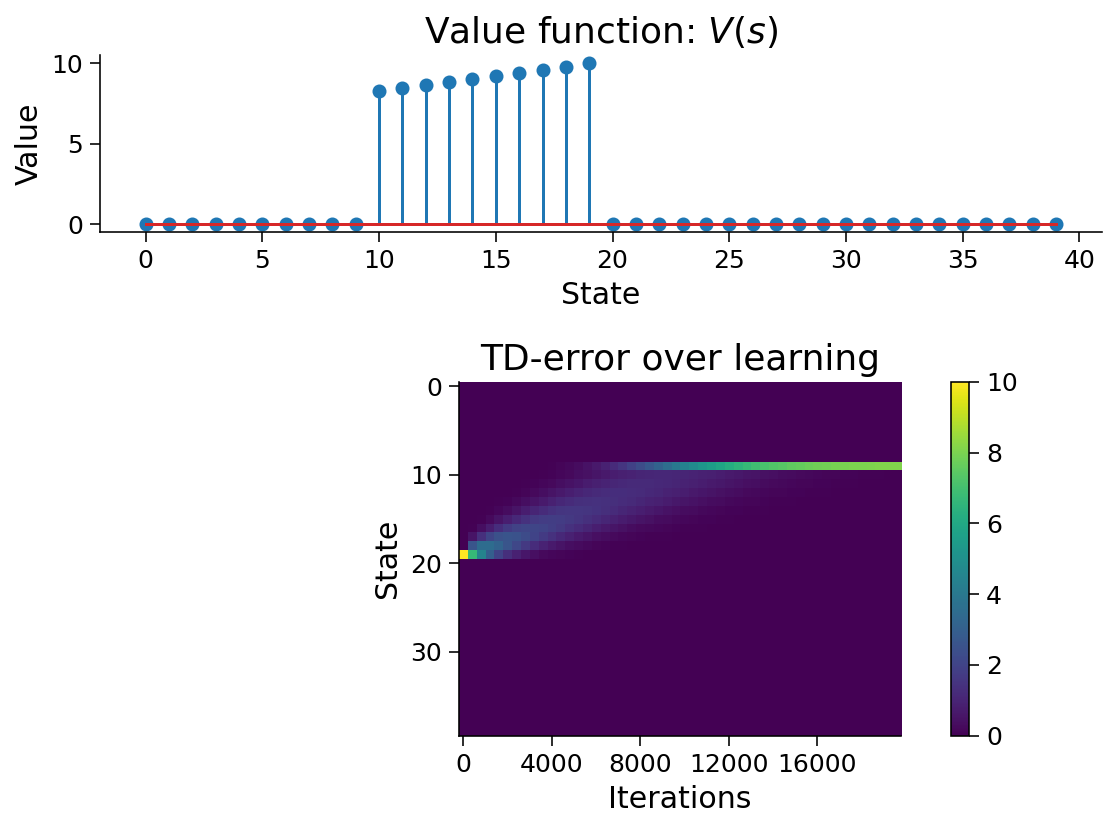

In [ ]:
def td_learner(env, n_trials, gamma=0.98, alpha=0.001):
  """ Temporal Difference learning

  Args:
    env (object): the environment to be learned
    n_trials (int): the number of trials to run
    gamma (float): temporal discount factor
    alpha (float): learning rate

  Returns:
    ndarray, ndarray: the value function and temporal difference error arrays
  """
  V = np.zeros(env.n_steps) # Array to store values over states (time)
  TDE = np.zeros((env.n_steps, n_trials)) # Array to store TD errors

  for n in range(n_trials):
    state = 0 # Initial state
    for t in range(env.n_steps):
      # Get next state and next reward
      next_state, reward = env.get_outcome(state)
      # Is the current state in the delay period (after CS)?
      is_delay = env.state_dict[state][0]

      ########################################################################
      ## TODO for students: implement TD error and value function update
      # Fill out function and remove
      # raise NotImplementedError("Student excercise: implement TD error and value function update")
      #################################################################################
      # Write an expression to compute the TD-error
      TDE[state, n] = (reward + gamma * V[next_state] - V[state])

      # Write an expression to update the value function
      V[state] += alpha * TDE[state, n] * is_delay

      # Update state
      state = next_state

  return V, TDE


# Uncomment once the td_learner function is complete
env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
V, TDE = td_learner(env, n_trials=20000)
learning_summary_plot(V, TDE)


*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial1_Solution_6f2c8b56_0.png>



### Interactive Demo 1: US to CS Transfer 

During classical conditioning, the subject's behavioral response (e.g., salivating) transfers from the unconditioned stimulus (US; like the smell of tasty food) to the conditioned stimulus (CS; like Pavlov ringing his bell) that predicts it. Reward prediction errors play an important role in this process by adjusting the value of states according to their expected, discounted return.

Use the widget below to examine how reward prediction errors change over time. Before training (orange line), only the reward state has high reward prediction error. As training progresses (blue line, slider), the reward prediction errors shift to the conditioned stimulus, where they end up when the trial is complete (green line). 

Dopamine neurons, which are thought to carry reward prediction errors _in vivo_, show exactly the same behavior!


In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

n_trials = 20000

@widgets.interact
def plot_tde_by_trial(trial = widgets.IntSlider(value=5000, min=0, max=n_trials-1 , step=1, description="Trial #")):
  if 'TDE' not in globals():
    print("Complete Exercise 1 to enable this interactive demo!")
  else:

    fig, ax = plt.subplots()
    ax.axhline(0, color='k') # Use this + basefmt=' ' to keep the legend clean.
    ax.stem(TDE[:, 0], linefmt='C1-', markerfmt='C1d', basefmt=' ',
            label="Before Learning (Trial 0)",
            use_line_collection=True)
    ax.stem(TDE[:, -1], linefmt='C2-', markerfmt='C2s', basefmt=' ',
            label="After Learning (Trial $\infty$)",
            use_line_collection=True)
    ax.stem(TDE[:, trial], linefmt='C0-', markerfmt='C0o', basefmt=' ',
            label=f"Trial {trial}",
            use_line_collection=True)

    ax.set_xlabel("State in trial")
    ax.set_ylabel("TD Error")
    ax.set_title("Temporal Difference Error by Trial")
    ax.legend()

interactive(children=(IntSlider(value=5000, description='Trial #', max=19999), Output()), _dom_classes=('widge…

### Interactive Demo 2: Learning Rates and Discount Factors

Our TD-learning agent has two parameters that control how it learns: $\alpha$, the learning rate, and $\gamma$, the discount factor. In Exercise 1, we set these parameters to $\alpha=0.001$ and $\gamma=0.98$ for you. Here, you'll investigate how changing these parameters alters the model that TD-learning learns.

Before enabling the interactive demo below, take a moment to think about the functions of these two parameters. $\alpha$ controls the size of the Value function updates produced by each TD-error. In our simple, deterministic world, will this affect the final model we learn? Is a larger $\alpha$ necessarily better in more complex, realistic environments?

The discount rate $\gamma$ applies an exponentially-decaying weight to returns occuring in the future, rather than the present timestep. How does this affect the model we learn? What happens when $\gamma=0$ or $\gamma \geq 1$?

Use the widget to test your hypotheses.




In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_summary_alpha_gamma(alpha = widgets.FloatSlider(value=0.0001, min=0.0001, max=0.1, step=0.0001, readout_format='.4f', description="alpha"),
                             gamma = widgets.FloatSlider(value=0.980, min=0, max=1.1, step=0.010, description="gamma")):
  env = ClassicalConditioning(n_steps=40, reward_magnitude=10, reward_time=10)
  try:
    V_params, TDE_params = td_learner(env, n_trials=20000, gamma=gamma, alpha=alpha)
  except NotImplementedError:
    print("Finish Exercise 1 to enable this interactive demo")

  learning_summary_plot(V_params,TDE_params)

interactive(children=(FloatSlider(value=0.0001, description='alpha', max=0.1, min=0.0001, readout_format='.4f'…

**Answer:**

Alpha determines how fast the model learns. In the simple, deterministic world
we're using here, this allows the moodel to quickly converge onto the "true"
model that heavily values the conditioned stimulus. In more complex environments,
however, excessively large values of alpha can slow, or even prevent, learning,
as we'll see later.
Gamma effectively controls how much the model cares about the future: larger values of
gamma cause the model to weight future rewards nearly as much as present ones. At gamma=1,
the model weights all rewards, regardless of when they occur, equally and when greater than one, it
starts to *prefer* rewards in the future, rather than the present (this is rarely good).
When gamma=0, however, the model becomes greedy and only considers rewards that
can be obtained immediately.

---
## Section 2: TD-learning with varying reward magnitudes

In the previous exercise, the environment was as simple as possible. On every trial, the CS predicted the same reward, at the same time, with 100% certainty. In the next few exercises, we will make the environment more progressively more complicated and examine the TD-learner's behavior. 


### Interactive Demo 3: Match the Value Functions

First, will replace the environment with one that dispenses one of several rewards, chosen at random. Shown below is the final value function $V$ for a TD learner that was trained in an enviroment where the CS predicted a reward of 6 or 14 units; both rewards were equally likely). 

Can you find another pair of rewards that cause the agent to learn the same value function? Assume each reward will be dispensed 50% of the time. 

Hints:
* Carefully consider the definition of the value function $V$. This can be solved analytically.
* There is no need to change $\alpha$ or $\gamma$. 
* Due to the randomness, there may be a small amount of variation.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

n_trials = 20000
np.random.seed(2020)
rng_state = np.random.get_state()
env = MultiRewardCC(40, [6, 14], reward_time=10)
V_multi, TDE_multi = td_learner(env, n_trials, gamma=0.98, alpha=0.001)

@widgets.interact
def reward_guesser_interaction(r1 = widgets.IntText(value=0, min=0, max=50, description="Reward 1"),
                               r2 = widgets.IntText(value=0, min=0, max=50, description="Reward 2")):
  try:
    env2 = MultiRewardCC(40, [r1, r2], reward_time=10)
    V_guess, _ = td_learner(env2, n_trials, gamma=0.98, alpha=0.001)
    fig, ax = plt.subplots()
    m, l, _ = ax.stem(V_multi, linefmt='y-', markerfmt='yo', basefmt=' ', label="Target",
            use_line_collection=True)
    m.set_markersize(15)
    m.set_markerfacecolor('none')
    l.set_linewidth(4)
    m, _, _ = ax.stem(V_guess, linefmt='r', markerfmt='rx', basefmt=' ', label="Guess",
                      use_line_collection=True)
    m.set_markersize(15)

    ax.set_xlabel("State")
    ax.set_ylabel("Value")
    ax.set_title("Guess V(s)\n" + reward_guesser_title_hint(r1, r2))
    ax.legend()
  except NotImplementedError:
    print("Please finish Exercise 1 first!")

interactive(children=(IntText(value=0, description='Reward 1'), IntText(value=0, description='Reward 2'), Outp…

### Section 2.1 Examining the TD Error

Run the cell below to plot the TD errors from our multi-reward environment. A new feature appears in this plot? What is it? Why does it happen?

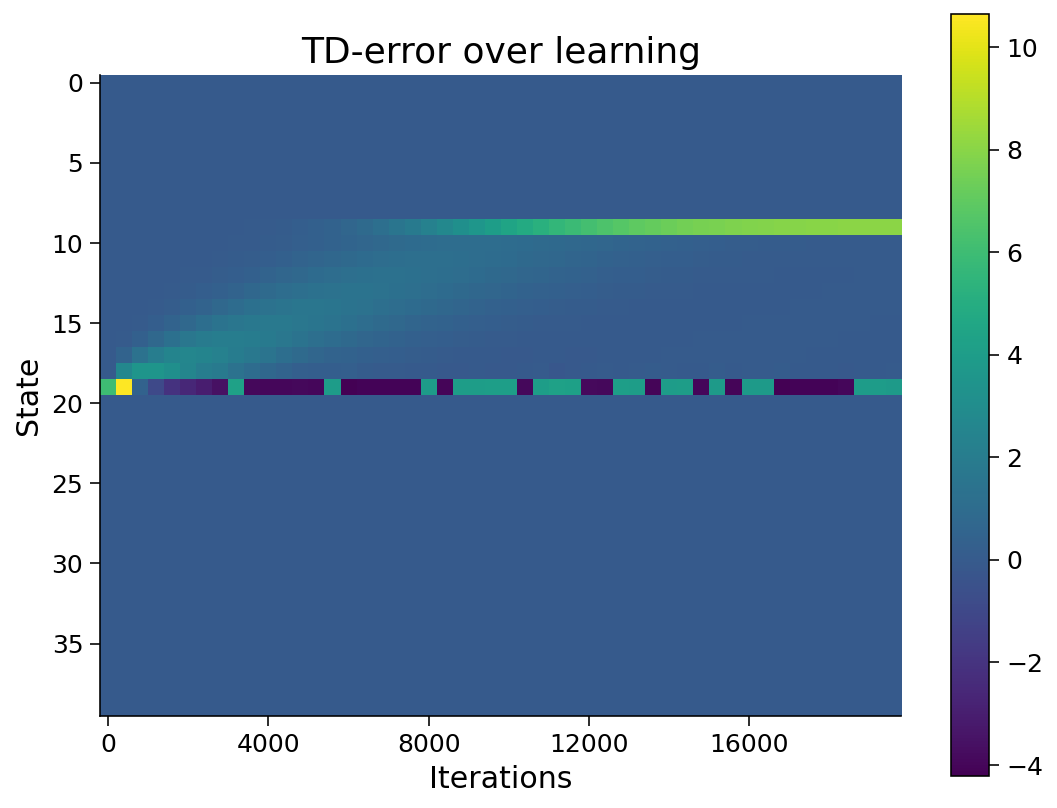

In [ ]:
plot_tde_trace(TDE_multi)

**Answer:**

The TD trace now takes on negative values because the reward delivered is
sometimes larger than the expected reward and sometimes smaller.

---
## Section 3: TD-learning with probabilistic rewards

In this environment, we'll return to delivering a single reward of ten units. However, it will be delivered intermittently: on 20 percent of trials, the CS will be shown but the agent will not receive the usual reward; the remaining 80% will proceed as usual.

 Run the cell below to simulate. How does this compare with the previous experiment?

Earlier in the notebook, we saw that changing $\alpha$ had little effect on learning in a deterministic environment. What happens if you set it to an large value, like 1, in this noisier scenario? Does it seem like it will _ever_ converge?

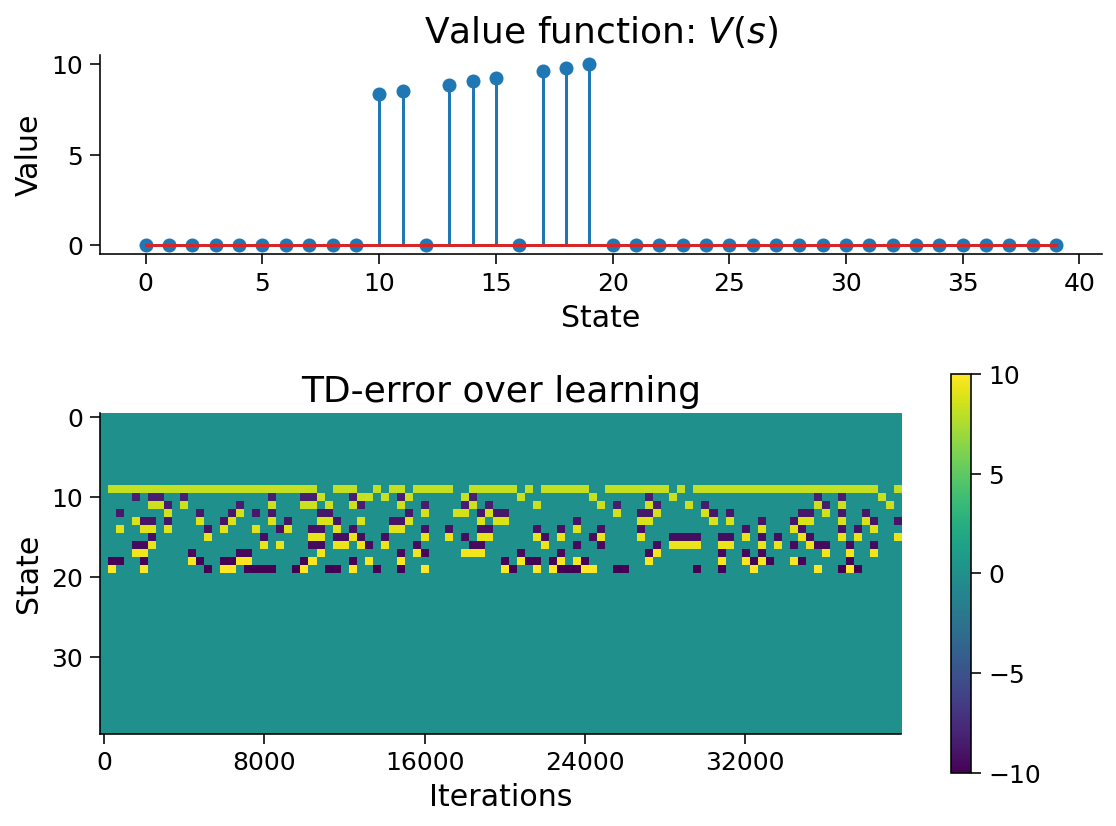

In [ ]:
np.random.set_state(rng_state) # Resynchronize everyone's notebooks
n_trials = 20000
try:
  env = ProbabilisticCC(n_steps=40, reward_magnitude=10, reward_time=10,
                        p_reward=0.8)
  V_stochastic, TDE_stochastic = td_learner(env, n_trials*2, alpha=1)
  learning_summary_plot(V_stochastic, TDE_stochastic)
except NotImplementedError:
  print("Please finish Exercise 1 first")

**Answer:**

The multi-reward and probabilistic reward enviroments are the same. You
could simulate a probabilistic reward of 10 units, delivered 50% of the time,
by having a mixture of 10 and 0 unit rewards, or vice versa. The takehome message
from these last three exercises is that the *average* or expected reward is
what matters during TD learning.
Large values of alpha prevent the TD Learner from converging. As a result, the
value function seems implausible: one state may have an extremely low value while
the neighboring ones remain high. This pattern persists even if training continues
for hundreds of thousands of trials.

---
## Summary

In this notebook, we have developed a simple TD Learner and examined how its state representations and reward prediction errors evolve during training. By manipualting its environment and parameters ($\alpha$, $\gamma$), you developed an intuition for how it behaves. 

This simple model closely resembles the behavior of subjects undergoing classical conditioning tasks and the dopamine neurons that may underlie that behavior. You may have implemented TD-reset or used the model to recreate a common experimental error. The update rule used here has been extensively studied for [more than 70 years](https://www.pnas.org/content/108/Supplement_3/15647) as a possible explanation for artificial and biological learning. 

However, you may have noticed that something is missing from this notebook. We carefully calculated the value of each state, but did not use it to actually do anything. Using values to plan _**Actions**_ is coming up next!

---

# Part 2
## Objectives
  
In this part you will use 'bandits' to understand the fundementals of how a policy interacts with the learning algorithm in reinforcement learning.
    
* You will understand the fundemental tradeoff between exploration and exploitation in a policy.
* You will understand how the learning rate interacts with exploration to find the best available action.

In [ ]:
#@title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Helper functions
np.set_printoptions(precision=3)

def plot_choices(q, epsilon, choice_fn, n_steps=1000, rng_seed=1):
  np.random.seed(rng_seed)
  counts = np.zeros_like(q)
  for t in range(n_steps):
    action = choice_fn(q, epsilon)
    counts[action] += 1

  fig, ax = plt.subplots()
  ax.bar(range(len(q)), counts/n_steps)
  ax.set(ylabel='% chosen', xlabel='action', ylim=(0,1), xticks=range(len(q)))


def plot_multi_armed_bandit_results(results):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 4))
  ax1.plot(results['rewards'])
  ax1.set(title=f"Total Reward: {np.sum(results['rewards']):.2f}",
          xlabel='step', ylabel='reward')
  ax2.plot(results['qs'])
  ax2.set(xlabel='step', ylabel='value')
  ax2.legend(range(len(results['mu'])))
  ax3.plot(results['mu'], label='latent')
  ax3.plot(results['qs'][-1], label='learned')
  ax3.set(xlabel='action', ylabel='value')
  ax3.legend()


def plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

  ax1.plot(np.mean(trial_rewards, axis=1).T)
  ax1.set(title=f'Average Reward ({fixed})', xlabel='step', ylabel='reward')
  ax1.legend(labels)

  ax2.plot(np.mean(trial_optimal, axis=1).T)
  ax2.set(title=f'Performance ({fixed})', xlabel='step', ylabel='% optimal')
  ax2.legend(labels)

---
## Section 1: Multi-Armed Bandits

Video available at https://youtu.be/kdiXr1zsfo0


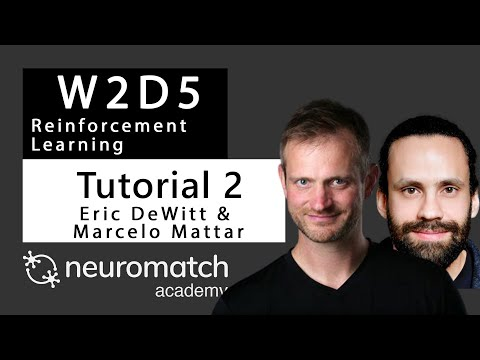

In [ ]:
#@title Video 1: Multi-Armed Bandits
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="kdiXr1zsfo0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

Consider the following learning problem. You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a reward signal in the form of a numerical value, where the larger value is the better. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

This is the original form of the k-armed bandit problem. This name derives from the colloquial name for a slot machine, the "one-armed bandit", because it has the one lever to pull, and it is often rigged to take more money than it pays out over time. The multi-armed bandit extension is to imagine, for instance, that you are faced with multiple slot machines that you can play, but only one at a time. Which machine should you play, i.e. which arm should you pull, which action should you take, at any given time to maximize your total payout.

<img alt="MultiArmedBandit" width="625" height="269" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial2_MultiarmedBandit.png?raw=true">


While there are many different levels of sophistication and assumptions in how the rewards are determined, for simplicity's sake we will assume that each action results in a reward drawn from a fixed Gaussian distribution with unknown mean and unit variance. This problem setting is referred to as the *environment*, and goal is to find the arm with the highest mean value.

We will solve this *optimization problem* with an *agent*, in this case an algorithm that takes in rewards and returns actions.

---
## Section 2: Choosing an Action
   
The first thing our agent needs to be able to do is choose which arm to pull. The strategy for choosing actions based on our expectations is called a *policy* (often denoted $\pi$). We could have a random policy -- just pick an arm at random each time -- though this doesn't seem likely to be capable of optimizing our reward. We want some intentionality, and to do that we need a way of describing our beliefs about the arms' reward potential. We do this with an action-value function

\begin{align}
q(a) = \mathbb{E} [r_{t} | a_{t} = a]
\end{align}

where the value $q$ for taking action $a \in A$ at time $t$ is equal to the expected value of the reward $r_t$ given that we took action $a$ at that time. In practice, this is often represented as an array of values, where each action's value is a different element in the array.

Great, now that we have a way to describe our beliefs about the values each action should return, let's come up with a policy.

An obvious choice would be to take the action with the highest expected value. This is referred to as the *greedy* policy

\begin{align}
a_{t} = \text{argmax}_{a} \; q_{t} (a)
\end{align}

where our choice action is the one that maximizes the current value function.

So far so good, but it can't be this easy. And, in fact, the greedy policy does have a fatal flaw: it easily gets trapped in local maxima. It never explores to see what it hasn't seen before if one option is already better than the others. This leads us to a fundamental challenge in coming up with effective polices.

### Section 2.1: The Exploitation-Exploration Dilemma

If we never try anything new, if we always stick to the safe bet, we don't know what we are missing. Sometimes we aren't missing much of anything, and regret not sticking with our preferred choice, yet other times we stumble upon something new that was way better than we thought.

This is the exploitation-exploration dilemma: do you go with you best choice now, or risk the less certain option with the hope of finding something better. Too much exploration, however, means you may end up with a sub-optimal reward once it's time to stop.

In order to avoid getting stuck in local minima while also maximizing reward, effective policies need some way to balance between these two aims.

A simple extension to our greedy policy is to add some randomness. For instance, a coin flip -- heads we take the best choice now, tails we pick one at random. This is referred to as the $\epsilon$-greedy policy:

\begin{align}
P (a_{t} = a) = 
        \begin{cases}
        1 - \epsilon + \epsilon/N    & \quad \text{if } a_{t} = \text{argmax}_{a} \; q_{t} (a) \\
        \epsilon/N        & \quad \text{else} 
        \end{cases} 
\end{align}

which is to say that with probability 1 - $\epsilon$ for $\epsilon \in [0,1]$ we select the greedy choice, and otherwise we select an action at random (including the greedy option).

Despite its relative simplicity, the epsilon-greedy policy is quite effective, which leads to its general popularity.

#### Exercise 1: Implement Epsilon-Greedy

In this exercise you will implement the epsilon-greedy algorithm for deciding which action to take from a set of possible actions given their value function and a probability $\epsilon$ of simply chosing one at random. 

TIP: You may find [`np.random.random`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html), [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), and [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) useful here.

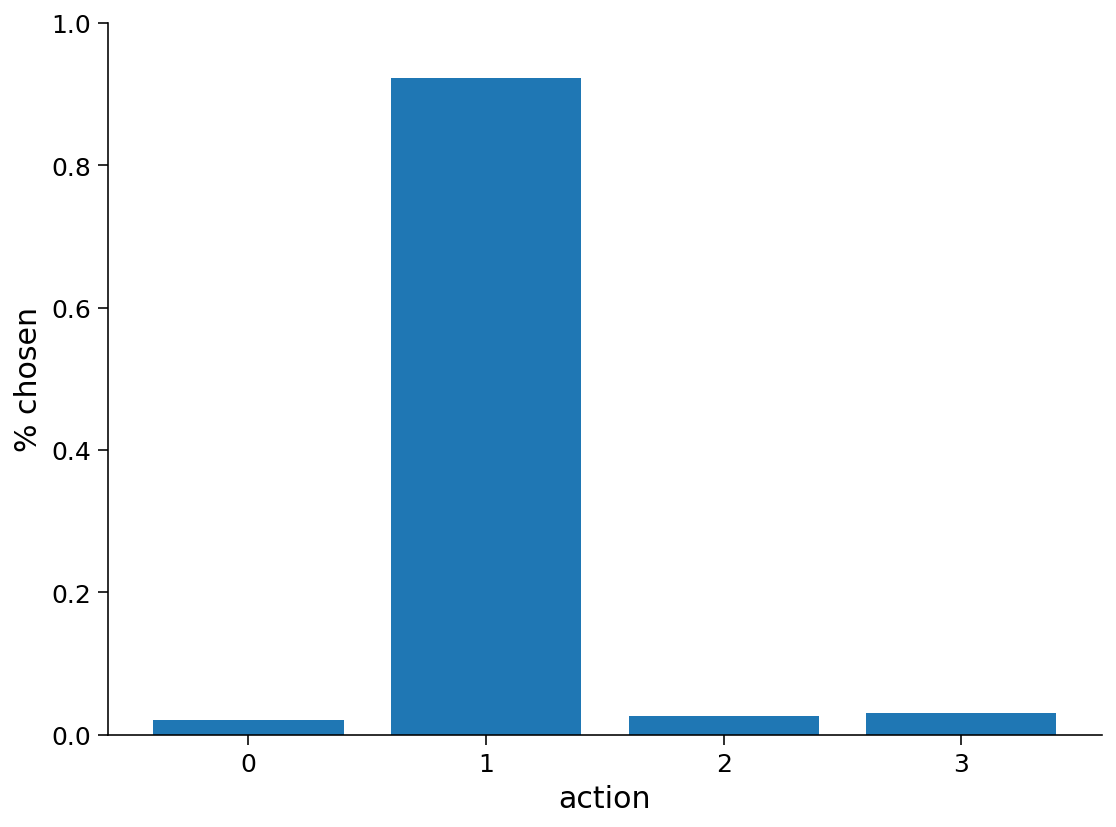

In [ ]:
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  #####################################################################
  ## TODO for students: implement the epsilon greedy decision algorithm
  # Fill out function and remove
  # raise NotImplementedError("Student excercise: implement the epsilon greedy decision algorithm")
  #####################################################################
    # write a boolean expression that determines if we should take the best action
  be_greedy = np.random.random() > epsilon
  if be_greedy:
    # write an expression for selecting the best action from the action values
    action = np.argmax(q)
  else:
    # write an expression for selecting a random action
    action = np.random.choice(len(q))
  return action


# Uncomment once the epsilon_greedy function is complete
q = [-2, 5, 0, 1]
epsilon = 0.1
plot_choices(q, epsilon, epsilon_greedy)


*Example output:*

<img alt='Solution hint' align='left' width=558 height=414 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial2_Solution_6f3c3877_0.png>



This is what we should expect, that the action with the largest value (action 1) is selected about (1-$\epsilon$) of the time, or 90% for $\epsilon = 0.1$, and the remaining 10% is split evenly amongst the other options. Use the demo below to explore how changing $\epsilon$ affects the distribution of selected actions.

#### Interactive Demo: Changing Epsilon

Epsilon is our one parameter for balancing exploitation and exploration.  Given a set of values $q = [-2, 5, 0, 1]$, use the widget below to see how changing $\epsilon$ influences our selection of the max value 5 (action = 1) vs the others. 

At the extremes of its range (0 and 1), the $\epsilon$-greedy policy reproduces two other policies. What are they?

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact(epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0))
def explore_epilson_values(epsilon=0.1):
  q = [-2, 5, 0, 1]
  plot_choices(q, epsilon, epsilon_greedy, rng_seed=None)

**Answer:**

When epsilon is zero, the agent always chooses the currently best option; it
becomes greedy. When epsilon is 1, the agent chooses randomly.

---
## Section 3: Learning from Rewards

Now that we have a policy for deciding what to do, how do we learn from our actions?

One way to do this is just keep a record of every result we ever got and use the averages for each action. If we have a potentially very long running episode, the computational cost of keeping all these values and recomputing the mean over and over again isn't ideal. Instead we can use a streaming mean calculation, which looks like this:

\begin{align}
q_{t+1}(a) \leftarrow q_{t}(a) + \frac{1}{n_t} (r_{t} - q_{t}(a))
\end{align}

where our action-value function $q_t(a)$ is the mean of the rewards seen so far, $n_t$ is the number of actions taken by time $t$, and $r_t$ is the reward just received for taking action $a$.

This still requires us to remember how many actions we've taken, so let's generalize this a bit further and replace the action total with a general parameter $\alpha$, which we will call the learning rate

\begin{align}
q_{t+1}(a) \leftarrow q_{t}(a) + \alpha (r_{t} - q_{t}(a)).
\end{align}

### Exercise 2: Updating Action Values

In this exercise you will implement the action-value update rule above. The function will take in the action-value function represented as an array `q`, the action taken, the reward received, and the learning rate, `alpha`. The function will return the updated value for the selection action.

In [ ]:
def update_action_value(q, action, reward, alpha):
  """ Compute the updated action value given the learning rate and observed
  reward.

  Args:
    q (ndarray): an array of action values
    action (int): the action taken
    reward (float): the reward received for taking the action
    alpha (float): the learning rate

  Returns:
    float: the updated value for the selected action
  """
  #####################################################
  ## TODO for students: compute the action value update
  # Fill out function and remove
  # raise NotImplementedError("Student excercise: compute the action value update")
  #####################################################
  # write an expression for the updated action value
  value = q[action] + alpha * (reward - q[action])
  return value


# Uncomment once the update_action_value function is complete
q = [-2, 5, 0, 1]
action = 2
print(f"Original q({action}) value = {q[action]}")
q[action] = update_action_value(q, 2, 10, 0.01)
print(f"Updated q({action}) value = {q[action]}")

Original q(2) value = 0
Updated q(2) value = 0.1


---
## Section 4: Solving Multi-Armed Bandits

Now that we have both a policy and a learning rule, we can combine these to solve our original multi-armed bandit task. Recall that we have some number of arms that give rewards drawn from Gaussian distributions with unknown mean and unit variance, and our goal is to find the arm with the highest mean.

First, let's see how we will simulate this environment by reading through the annotated code below.

In [ ]:
def multi_armed_bandit(n_arms, epsilon, alpha, n_steps):
  """ A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
  action, rewards are randomly sampled from normal distribution, with a mean
  associated with that arm and unit variance.

  Args:
    n_arms (int): number of arms or actions
    epsilon (float): probability of selecting an action randomly
    alpha (float): the learning rate
    n_steps (int): number of steps to evaluate

  Returns:
    dict: a dictionary containing the action values, actions, and rewards from
    the evaluation along with the true arm parameters mu and the optimality of
    the chosen actions.
  """
  # Gaussian bandit parameters
  mu = np.random.normal(size=n_arms)

  # evaluation and reporting state
  q = np.zeros(n_arms)
  qs = np.zeros((n_steps, n_arms))
  rewards = np.zeros(n_steps)
  actions = np.zeros(n_steps)
  optimal = np.zeros(n_steps)

  # run the bandit
  for t in range(n_steps):
    # choose an action
    action = epsilon_greedy(q, epsilon)
    actions[t] = action

    # copmute rewards for all actions
    all_rewards = np.random.normal(mu)
    # observe the reward for the chosen action
    reward = all_rewards[action]
    rewards[t] = reward
    # was it the best possible choice?
    optimal_action = np.argmax(all_rewards)
    optimal[t] = action == optimal_action

    # update the action value
    q[action] = update_action_value(q, action, reward, alpha)
    qs[t] = q

  results = {
      'qs': qs,
      'actions': actions,
      'rewards': rewards,
      'mu': mu,
      'optimal': optimal
  }

  return results

We can use our multi-armed bandit method to evaluate how our epsilon-greedy policy and learning rule perform at solving the task. First we will set our environment to have 10 arms and our agent parameters to $\epsilon=0.1$ and $\alpha=0.01$. In order to get a good sense of the agent's performance, we will run the episode for 1000 steps.

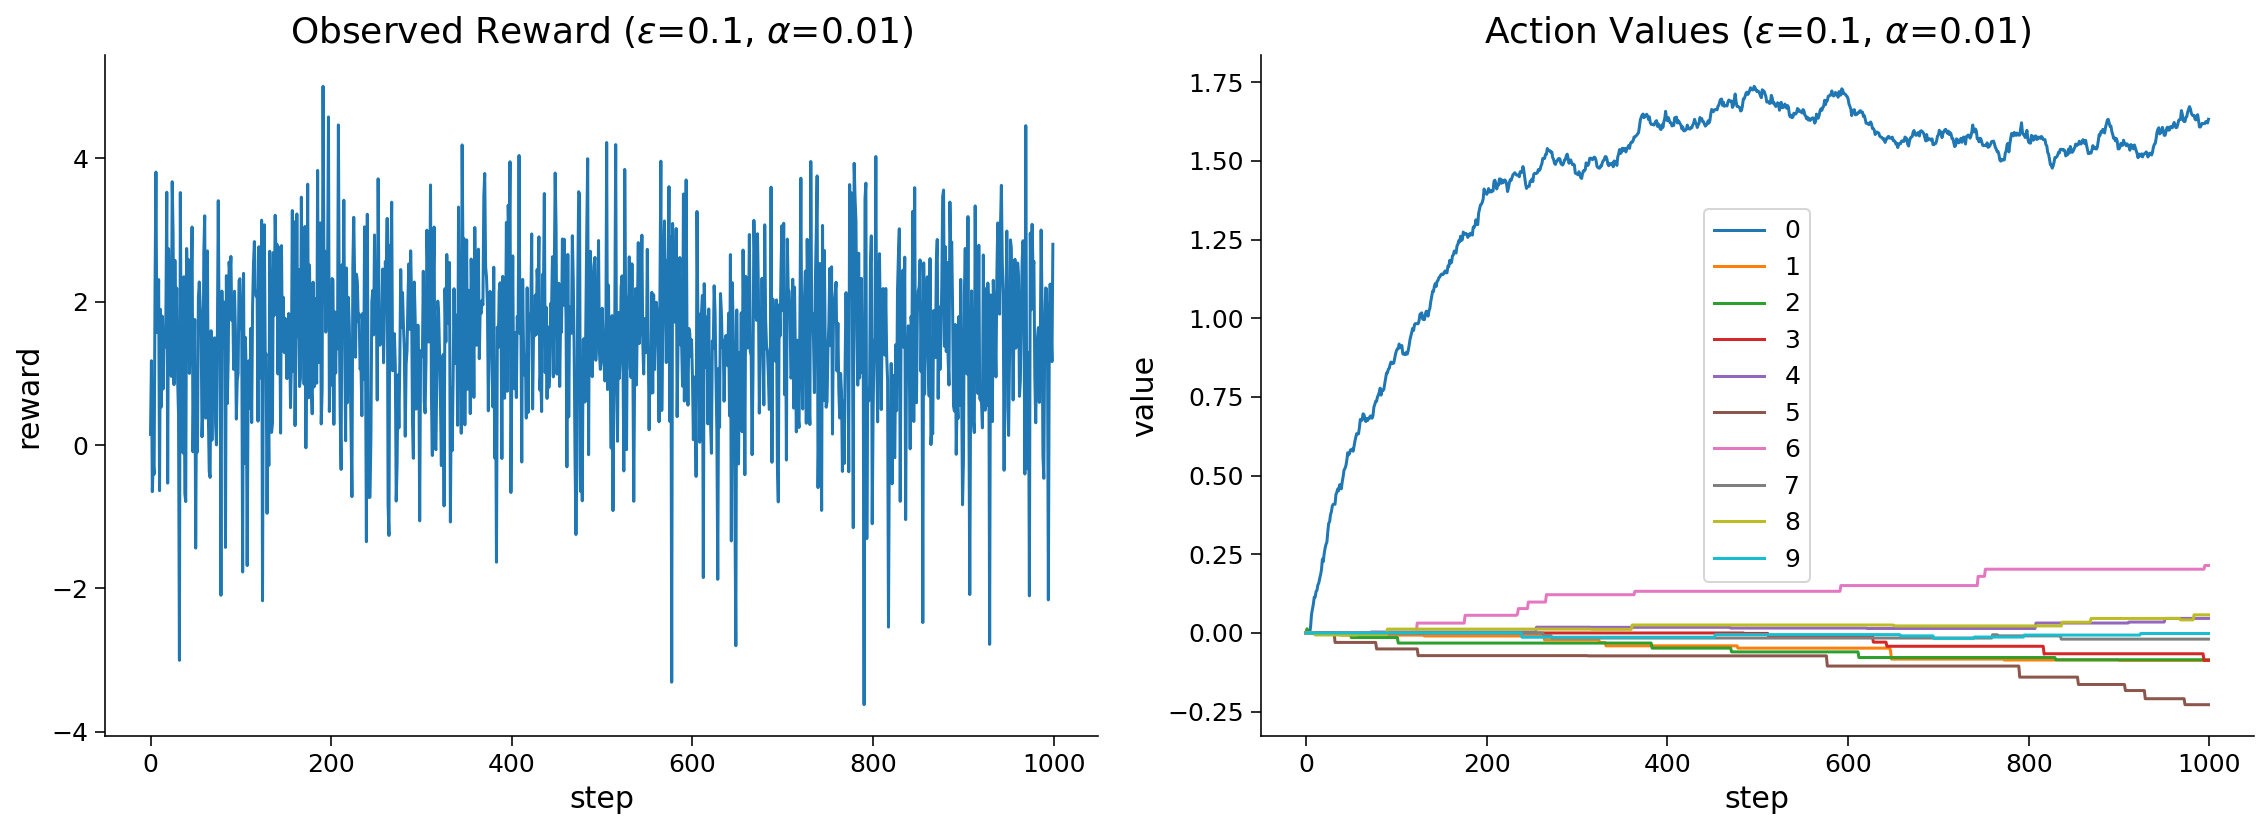

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

n_arms = 10
epsilon = 0.1
alpha = 0.01
n_steps = 1000

results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(results['rewards'])
ax1.set(title=f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='reward')
ax2.plot(results['qs'])
ax2.set(title=f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='value')
ax2.legend(range(n_arms));

Alright, we got some rewards that are kind of all over the place, but the agent seemed to settle in on the first arm as the preferred choice of action relatively quickly. Let's see how well we did at recovering the true means of the Gaussian random variables behind the arms.

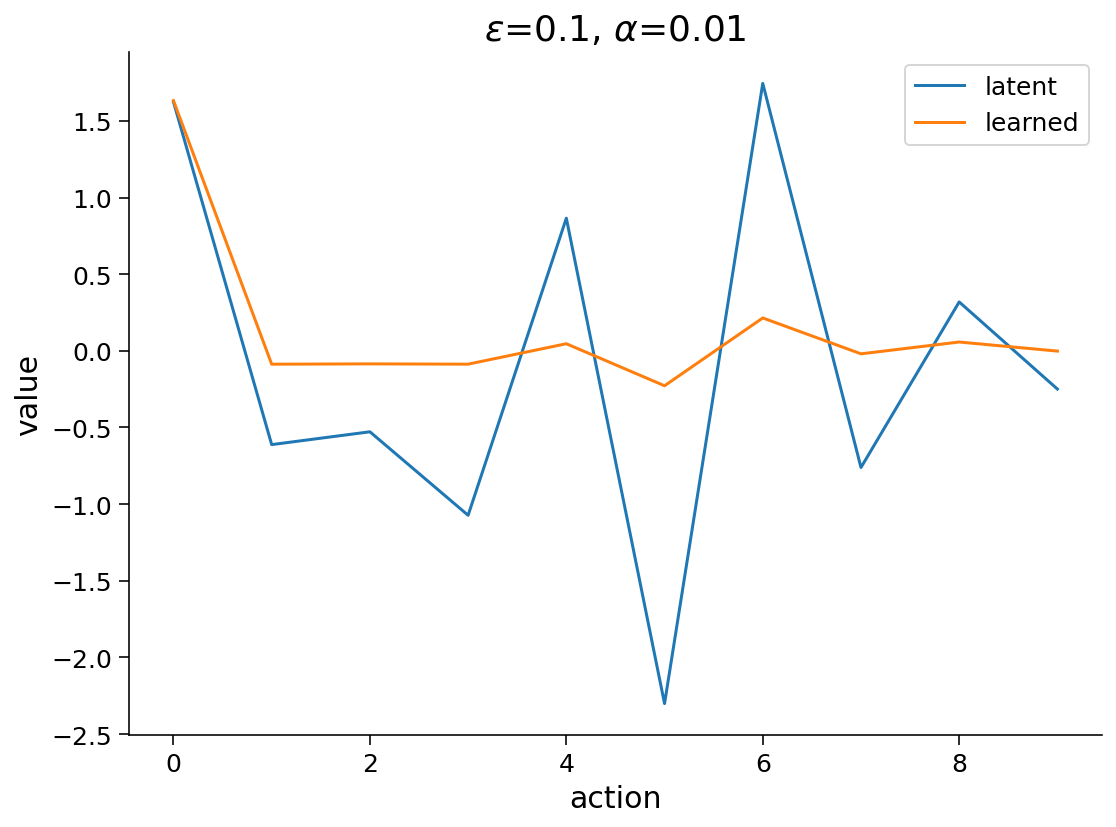

In [ ]:
fig, ax = plt.subplots()
ax.plot(results['mu'], label='latent')
ax.plot(results['qs'][-1], label='learned')
ax.set(title=f'$\epsilon$={epsilon}, $\\alpha$={alpha}',
       xlabel='action', ylabel='value')
ax.legend();

Well, we seem to have found a very good estimate for action 0, but most of the others are not great. In fact, we can see the effect of the local maxima trap at work -- the greedy part of our algorithm locked onto action 0, which is actually the 2nd best choice to action 6. Since these are the means of Gaussian random variables, we can see that the overlap between the two would be quite high, so even if we did explore action 6, we may draw a sample that is still lower than our estimate for action 0.

However, this was just one choice of parameters. Perhaps there is a better combination?



### Interactive Demo: Changing Epsilon and Alpha

Use the widget below to explore how varying the values of $\epsilon$ (exploitation-exploration tradeoff), $\alpha$ (learning rate), and even the number of actions $k$, changes the behavior of our agent.

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

@widgets.interact_manual(k=widgets.IntSlider(10, min=2, max=15),
                         epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0),
                         alpha=widgets.FloatLogSlider(0.01, min=-3, max=0))
def explore_bandit_parameters(k=10, epsilon=0.1, alpha=0.001):
  results = multi_armed_bandit(k, epsilon, alpha, 1000)
  plot_multi_armed_bandit_results(results)

interactive(children=(IntSlider(value=10, description='k', max=15, min=2), FloatSlider(value=0.1, description=…

While we can see how changing the epsilon and alpha values impact the agent's behavior, this doesn't give as a great sense of which combination is optimal. Due to the stochastic nature of both our rewards and our policy, a single trial run isn't sufficient to give us this information. Let's run mulitple trials and compare the average performance.

First we will look at differet values for $\epsilon \in [0.0, 0.1, 0.2]$ to a fixed $\alpha=0.1$. We will run 200 trials as a nice balance between speed and accuracy.

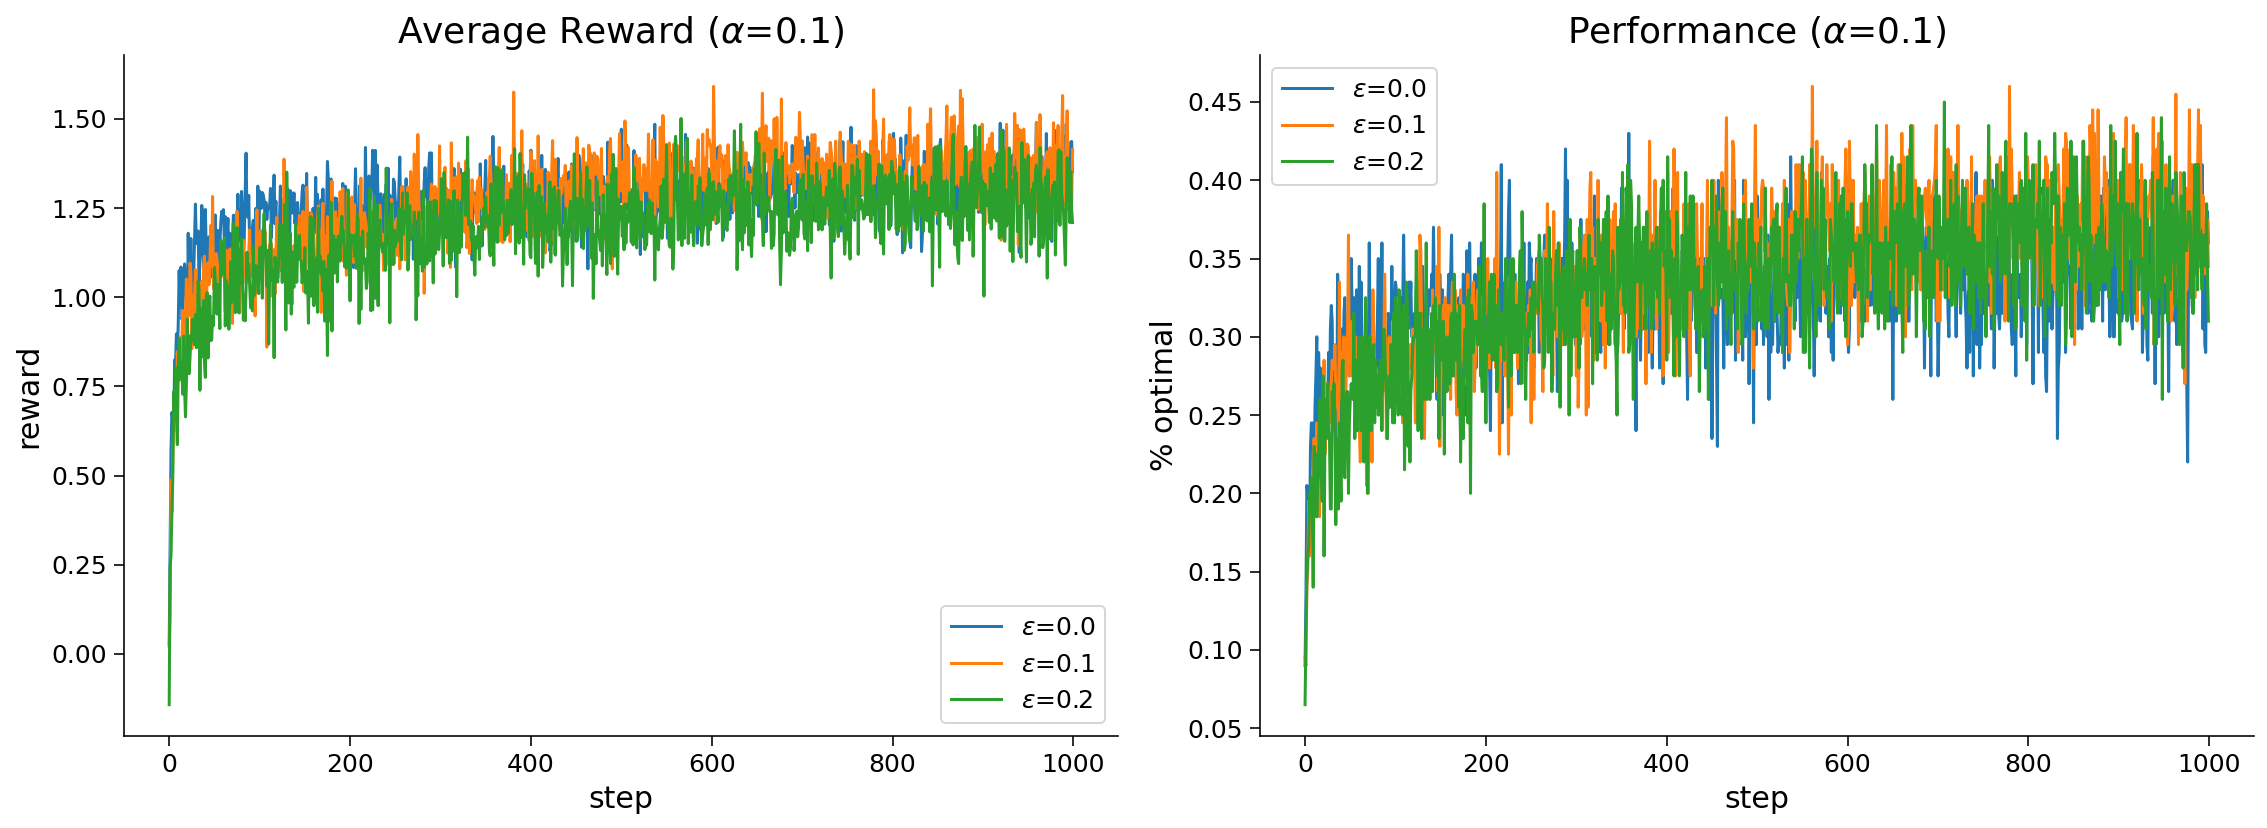

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilons = [0.0, 0.1, 0.2]
alpha = 0.1
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, epsilon in enumerate(epsilons):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\epsilon$={e}' for e in epsilons]
fixed = f'$\\alpha$={alpha}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

On the left we have plotted the average reward over time, and we see that while $\epsilon=0$ (the greedy policy) does well initially, $\epsilon=0.1$ starts to do slightly better in the long run, while $\epsilon=0.2$ does the worst. Looking on the right, we see the percentage of times the optimal action (the best possible choice at time $t$) was taken, and here again we see a similar pattern of $\epsilon=0.1$ starting out a bit slower but eventually having a slight edge in the longer run.

We can also do the same for the learning rates. We will evaluate $\alpha \in [0.01, 0.1, 1.0]$ to a fixed $\epsilon=0.1$.

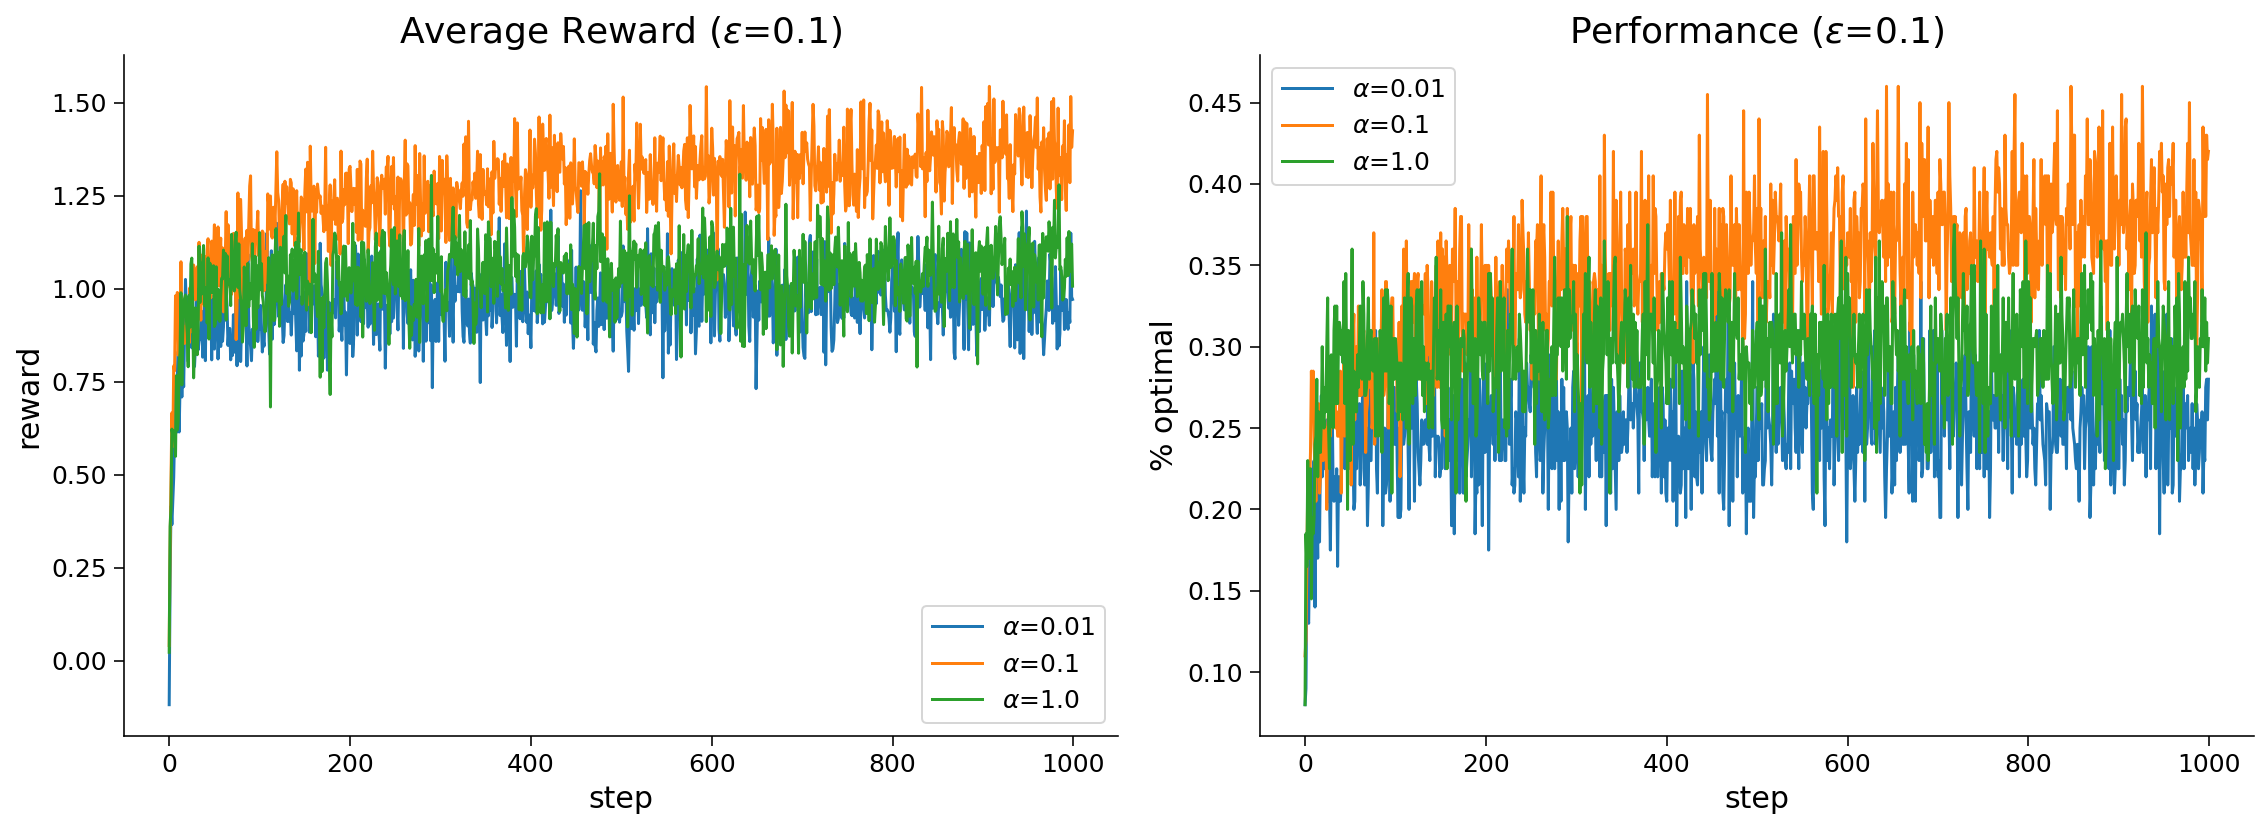

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilon = 0.1
alphas = [0.01, 0.1, 1.0]
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, alpha in enumerate(alphas):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\\alpha$={a}' for a in alphas]
fixed = f'$\epsilon$={epsilon}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

Again we see a balance between an effective learning rate. $\alpha=0.01$ is too weak to quickly incorporate good values, while $\alpha=1$ is too strong likely resulting in high variance in values due to the Gaussian nature of the rewards.

---
## Summary

In this tutorial you implemented both the epsilon-greedy descision algorithm and a learning rule for solving a multi-armed bandit scenario. You saw how balancing exploitation and exploration in action selection is crtical in finding optimal solutions. You also saw how choosing an appropriate learning rate determines how well an agent can generalize the information they receive from rewards.


---
# Part 3
## Objectives
  
In this part you will learn how to act in the more realistic setting of sequential decisions, formalized by Markov Decision Processes (MDPs). In a sequential decision problem, the actions executed in one state not only may lead to immediate rewards (as in a bandit problem), but may also affect the states experienced next (unlike a bandit problem). Each individual action may therefore affect affect all future rewards. Thus, making decisions in this setting requires considering each action in terms of their expected **cumulative** future reward.

We will consider here the example of spatial navigation, where actions (movements) in one state (location) affect the states experienced next, and an agent might need to execute a whole sequence of actions before a reward is obtained.

By the end of this part, you will learn
* what grid worlds are and how they help in evaluating simple reinforcement learning agents
* the basics of the Q-learning algorithm for estimating action values
* how the concept of exploration and exploitation, reviewed in the bandit case, also applies to the sequential decision setting

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv

In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Helper functions
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  if np.random.random() > epsilon:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action


class CliffWorld:
  """
  World: Cliff world.
  40 states (4-by-10 grid world).
  The mapping from state to the grids are as follows:
  30 31 32 ... 39
  20 21 22 ... 29
  10 11 12 ... 19
  0  1  2  ...  9
  0 is the starting state (S) and 9 is the goal state (G).
  Actions 0, 1, 2, 3 correspond to right, up, left, down.
  Moving anywhere from state 9 (goal state) will end the session.
  Taking action down at state 11-18 will go back to state 0 and incur a
      reward of -100.
  Landing in any states other than the goal state will incur a reward of -1.
  Going towards the border when already at the border will stay in the same
      place.
  """
  def __init__(self):
    self.name = "cliff_world"
    self.n_states = 40
    self.n_actions = 4
    self.dim_x = 10
    self.dim_y = 4
    self.init_state = 0

  def get_outcome(self, state, action):
    if state == 9:  # goal state
      reward = 0
      next_state = None
      return next_state, reward
    reward = -1  # default reward value
    if action == 0:  # move right
      next_state = state + 1
      if state % 10 == 9:  # right border
        next_state = state
      elif state == 0:  # start state (next state is cliff)
        next_state = None
        reward = -100
    elif action == 1:  # move up
      next_state = state + 10
      if state >= 30:  # top border
        next_state = state
    elif action == 2:  # move left
      next_state = state - 1
      if state % 10 == 0:  # left border
        next_state = state
    elif action == 3:  # move down
      next_state = state - 10
      if state >= 11 and state <= 18:  # next is cliff
        next_state = None
        reward = -100
      elif state <= 9:  # bottom border
        next_state = state
    else:
      print("Action must be between 0 and 3.")
      next_state = None
      reward = None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes = {}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state, reward = self.get_outcome(state, action)
        outcomes[state, action] = [(1, next_state, reward)]
    return outcomes


def learn_environment(env, learning_rule, params, max_steps, n_episodes):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)

  # Loop over episodes
  for episode in range(n_episodes):
    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # update value function
      value = learning_rule(state, action, reward, next_state, value, params)

      # sum rewards obtained
      reward_sum += reward

      if next_state is None:
          break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum

  return value, reward_sums


def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

---
## Section 1: Markov Decision Processes

Video available at https://youtu.be/8yvwMrUQJOU


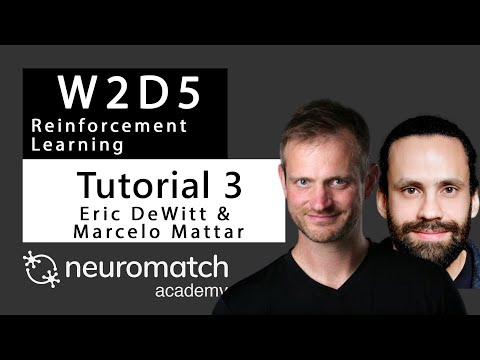

In [ ]:
#@title Video 1: MDPs and Q-learning
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="8yvwMrUQJOU", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

### Section 1.1: Grid Worlds

As pointed out, bandits only have a single state and immediate rewards for our actions. Many problems we are interested in have multiple states and delayed rewards, i.e. we won't know if the choices we made will pay off over time, or which actions we took contributed to the outcomes we observed.

In order to explore these ideas, we turn the a common problem setting: the grid world. Grid worlds are simple environments where each state corresponds to a tile on a 2D grid, and the only actions the agent can take are to move up, down, left, or right across the grid tiles. The agent's job is almost always to find a way to a goal tile in the most direct way possible while overcoming some maze or other obstacles, either static or dynamic.

For our discussion we will be looking at the classic Cliff World, or Cliff Walker, environment. This is a 4x10 grid with a starting position in the lower-left and the goal position in the lower-right. Every tile between these two is the "cliff", and should the agent enter the cliff, they will receive a -100 reward and be sent back to the starting position. Every tile other than the cliff produces a -1 reward when entered. The goal tile ends the episode after taking any action from it.

<img alt="CliffWorld" width="577" height="308" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial3_CliffWorld.png?raw=true">

Given these conditions, the maximum achievable reward is -11 (1 up, 9 right, 1 down). Using negative rewards is a common technique to encourage the agent to move and seek out the goal state as fast as possible.

---
## Section 2: Q-Learning

Now that we have our environment, how can we solve it? 

One of the most famous algorithms for estimating action values (aka Q-values) is the Temporal Differences (TD) **control** algorithm known as *Q-learning* (Watkins, 1989). 

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

where $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

The expression $r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1})$ is referred to as the TD target while the full expression 
\begin{align}
r_t + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t),
\end{align}
i.e. the difference between the TD target and the current Q-value, is referred to as the TD error, or reward prediction error.

Because of the max operator used to select the optimal Q-value in the TD target, Q-learning directly estimates the optimal action value, i.e. the cumulative future reward that would be obtained if the agent behaved optimally, regardless of the policy currently followed by the agent. For this reason, Q-learning is referred to as an **off-policy** method.

### Exercise 1: Implement the Q-learning algorithm

In this exercise you will implement the Q-learning update rule described above. It takes in as arguments the previous state $s_t$, the action $a_t$ taken, the reward received $r_t$, the current state $s_{t+1}$, the Q-value table, and a dictionary of parameters that contain the learning rate $\alpha$ and discount factor $\gamma$. The method returns the updated Q-value table. For the parameter dictionary, $\alpha$: `params['alpha']` and $\gamma$: `params['gamma']`. 


In [ ]:
def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Q-value of current state-action pair
  q = value[state, action]

  ##########################################################
  ## TODO for students: implement the Q-learning update rule
  # Fill out function and remove
  # raise NotImplementedError("Student excercise: implement the Q-learning update rule")
  ##########################################################

  # write an expression for finding the maximum Q-value at the current state
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])

  # write the expression to compute the TD error
  td_error = reward + params['gamma'] * max_next_q - q
  # write the expression that updates the Q-value for the state-action pair
  value[state, action] = q + params['alpha'] * td_error

  return value

Now that we have our Q-learning algorithm, let's see how it handles learning to solve the Cliff World environment. 

You will recall from the previous tutorial that a major part of reinforcement learning algorithms are their ability to balance exploitation and exploration. For our Q-learning agent, we again turn to the epsilon-greedy strategy. At each step, the agent will decide with probability $1 - \epsilon$ to use the best action for the state it is currently in by looking at the value function, otherwise just make a random choice.

The process by which our the agent will interact with and learn about the environment is handled for you in the helper function `learn_environment`. This implements the entire learning episode lifecycle of stepping through the state observation, action selection (epsilon-greedy) and execution, reward, and state transition. Feel free to review that code later to see how it all fits together, but for now let's test out our agent.

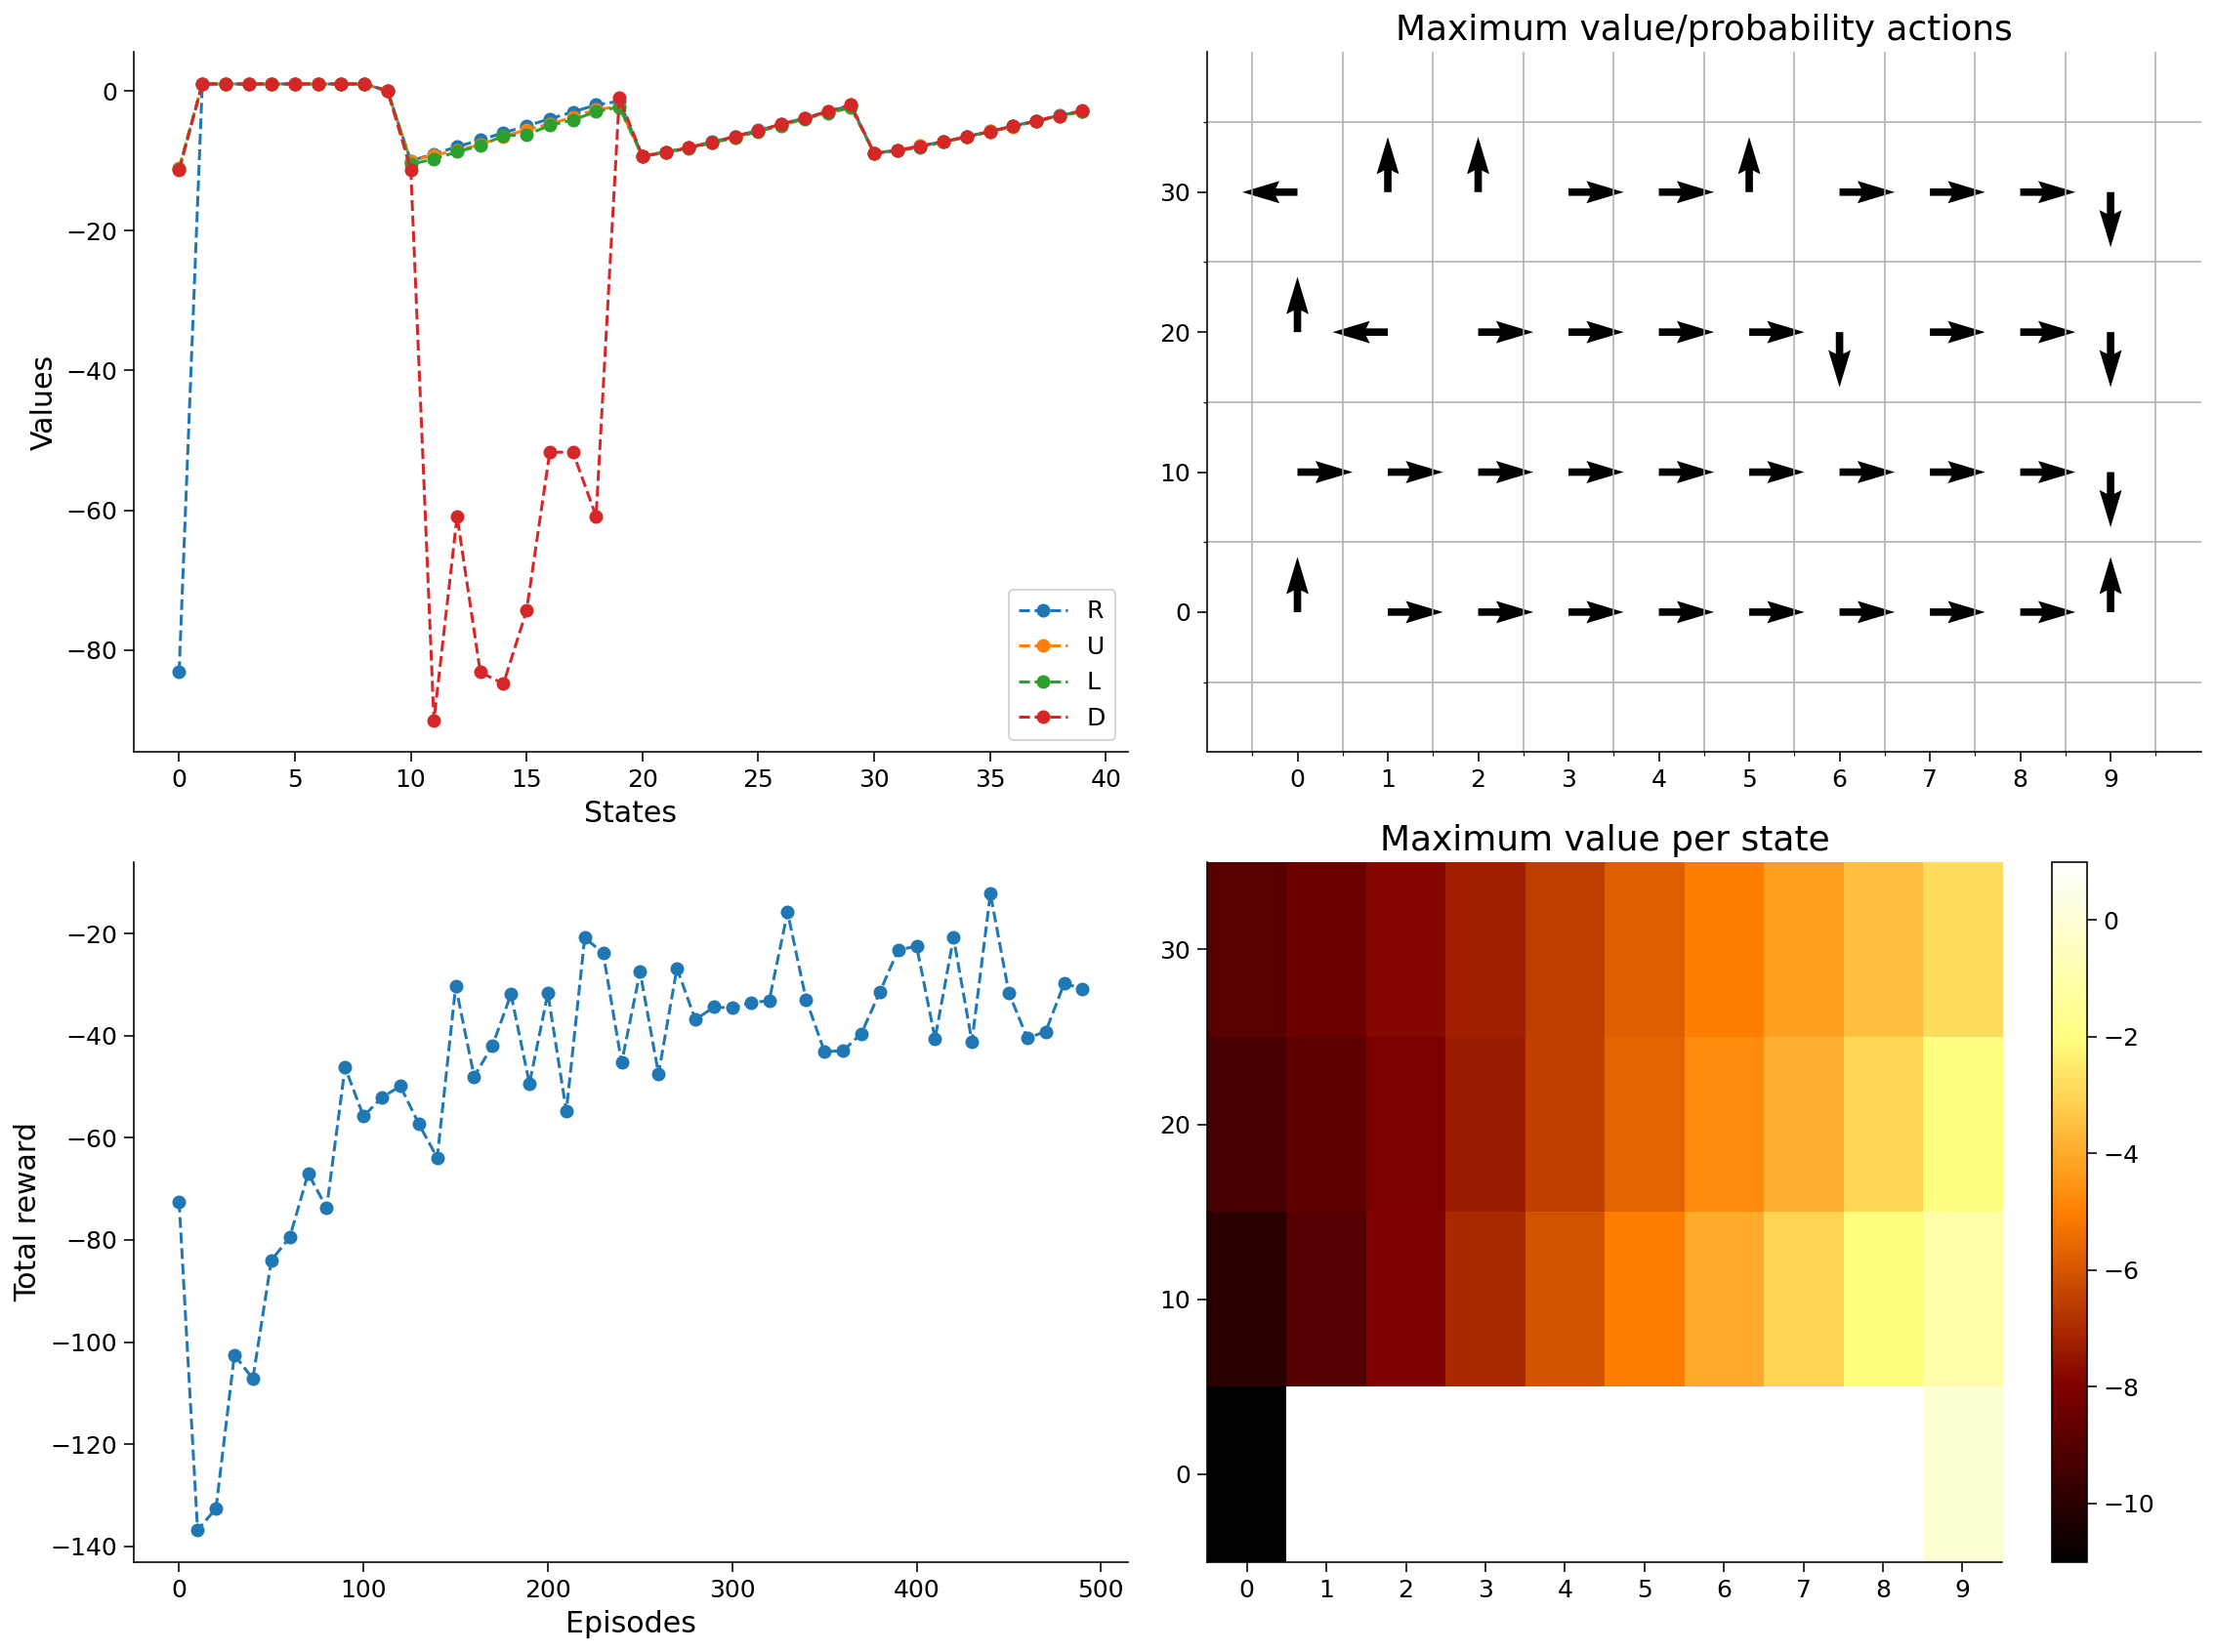

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.1,  # epsilon-greedy policy
  'alpha': 0.1,  # learning rate
  'gamma': 1.0,  # discount factor
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = CliffWorld()

# solve Cliff World using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_qlearning, reward_sums_qlearning = results

# Plot results
plot_performance(env, value_qlearning, reward_sums_qlearning)

If all went well, we should see four plots that show different aspects on our agent's learning and progress.

* The top left is a representation of the Q-table itself, showing the values for different actions in different states. Notably, going right from the starting state or down when above the cliff is clearly very bad.
* The top right figure shows the greedy policy based on the Q-table, i.e. what action would the agent take if it only took its best guess in that state.
* The bottom right is the same as the top, only instead of showing the action, it's showing a representation of the maximum Q-value at a particular state.
* The bottom left is the actual proof of learning, as we see the total reward steadily increasing after each episode until asymptoting at the maximum possible reward of -11.

Feel free to try changing the parameters or random seed and see how the agent's behavior changes.

---
## Summary

In this tutorial you implemented a reinforcement learning agent based on Q-learning to solve the Cliff World environment. Q-learning combined the epsilon-greedy approach to exploration-expoitation with a table-based value function to learn the expected future rewards for each state.

---
# Part 4
# Objectives
  
In this part you will implement one of the simplest model-based Reinforcement Learning algorithms, Dyna-Q. You will understand what a world model is, how it can improve the agent's policy, and the situations in which model-based algorithms are more advantagenous than their model-free counterparts.
    
* You will implement a model-based RL agent, Dyna-Q, that can solve a simple task;
* You will investigate the effect of planning on the agent's behavior;
* You will compare the behaviors of a model-based and model-free agent in light of an environmental change.

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve as conv

In [ ]:
#@title Figure settings
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
#@title Helper functions
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probabilty
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  be_greedy = np.random.random() > epsilon
  if be_greedy:
    action = np.argmax(q)
  else:
    action = np.random.choice(len(q))

  return action


def q_learning(state, action, reward, next_state, value, params):
  """Q-learning: updates the value function and returns it.

  Args:
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing the default parameters

  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # value of previous state-action pair
  prev_value = value[int(state), int(action)]

  # maximum Q-value at current state
  if next_state is None or np.isnan(next_state):
      max_value = 0
  else:
      max_value = np.max(value[int(next_state)])

  # reward prediction error
  delta = reward + params['gamma'] * max_value - prev_value

  # update value of previous state-action pair
  value[int(state), int(action)] = prev_value + params['alpha'] * delta

  return value


def learn_environment(env, model_updater, planner, params, max_steps,
                      n_episodes, shortcut_episode=None):
  # Start with a uniform value function
  value = np.ones((env.n_states, env.n_actions))

  # Run learning
  reward_sums = np.zeros(n_episodes)
  episode_steps = np.zeros(n_episodes)

  # Dyna-Q state
  model = np.nan*np.zeros((env.n_states, env.n_actions, 2))

  # Loop over episodes
  for episode in range(n_episodes):
    if shortcut_episode is not None and episode == shortcut_episode:
      env.toggle_shortcut()
      state = 64
      action = 1
      next_state, reward = env.get_outcome(state, action)
      model[state, action] = reward, next_state
      value = q_learning(state, action, reward, next_state, value, params)


    state = env.init_state  # initialize state
    reward_sum = 0

    for t in range(max_steps):
      # choose next action
      action = epsilon_greedy(value[state], params['epsilon'])

      # observe outcome of action on environment
      next_state, reward = env.get_outcome(state, action)

      # sum rewards obtained
      reward_sum += reward

      # update value function
      value = q_learning(state, action, reward, next_state, value, params)

      # update model
      model = model_updater(model, state, action, reward, next_state)
      # execute planner
      value = planner(model, value, params)

      if next_state is None:
        break  # episode ends
      state = next_state

    reward_sums[episode] = reward_sum
    episode_steps[episode] = t+1

  return value, reward_sums, episode_steps


class world(object):
    def __init__(self):
        return

    def get_outcome(self):
        print("Abstract method, not implemented")
        return

    def get_all_outcomes(self):
        outcomes = {}
        for state in range(self.n_states):
            for action in range(self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

class QuentinsWorld(world):
    """
    World: Quentin's world.
    100 states (10-by-10 grid world).
    The mapping from state to the grid is as follows:
    90 ...       99
    ...
    40 ...       49
    30 ...       39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9
    54 is the start state.
    Actions 0, 1, 2, 3 correspond to right, up, left, down.
    Moving anywhere from state 99 (goal state) will end the session.
    Landing in red states incurs a reward of -1.
    Landing in the goal state (99) gets a reward of 1.
    Going towards the border when already at the border will stay in the same
        place.
    """
    def __init__(self):
        self.name = "QuentinsWorld"
        self.n_states = 100
        self.n_actions = 4
        self.dim_x = 10
        self.dim_y = 10
        self.init_state = 54
        self.shortcut_state = 64

    def toggle_shortcut(self):
      if self.shortcut_state == 64:
        self.shortcut_state = 2
      else:
        self.shortcut_state = 64

    def get_outcome(self, state, action):
        if state == 99:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = 0  # default reward value
        if action == 0:  # move right
            next_state = state + 1
            if state == 98:  # next state is goal state
                reward = 1
            elif state % 10 == 9:  # right border
                next_state = state
            elif state in [11, 21, 31, 41, 51, 61, 71,
                           12, 72,
                           73,
                           14, 74,
                           15, 25, 35, 45, 55, 65, 75]:  # next state is red
                reward = -1
        elif action == 1:  # move up
            next_state = state + 10
            if state == 89:  # next state is goal state
                reward = 1
            if state >= 90:  # top border
                next_state = state
            elif state in [2, 12, 22, 32, 42, 52, 62,
                           3, 63,
                           self.shortcut_state,
                           5, 65,
                           6, 16, 26, 36, 46, 56, 66]:  # next state is red
                reward = -1
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0:  # left border
                next_state = state
            elif state in [17, 27, 37, 47, 57, 67, 77,
                           16, 76,
                           75,
                           14, 74,
                           13, 23, 33, 43, 53, 63, 73]:  # next state is red
                reward = -1
        elif action == 3:  # move down
            next_state = state - 10
            if state <= 9:  # bottom border
                next_state = state
            elif state in [22, 32, 42, 52, 62, 72, 82,
                           23, 83,
                           84,
                           25, 85,
                           26, 36, 46, 56, 66, 76, 86]:  # next state is red
                reward = -1
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward


# HELPER FUNCTIONS FOR PLOTTING

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')


def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')


def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0,0])
  plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1,0])
  im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  fig.colorbar(im)

---

## Section 1: Model-based RL

Video available at https://youtu.be/zT_legTotF0


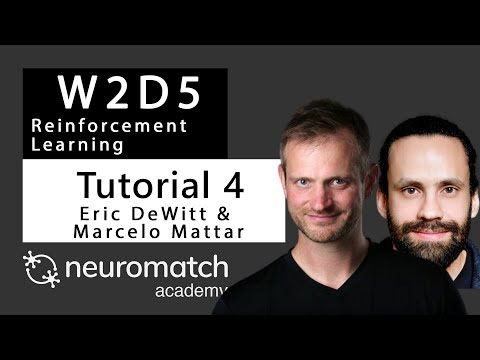

In [ ]:
#@title Video 1: Model-based RL
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="zT_legTotF0", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

The algorithms introduced in the previous tutorials are all *model-free*, as they do not require a model to use or control behavior. In this section, we will study a different class of algorithms called model-based. As we will see next, in contrast to model-free RL, model-based methods use a model to build a policy.

But what is a model? A model (sometimes called a world model or internal model) is a representation of how the world will respond to the agent's actions. You can think of it as a representation of how the world *works*. With such a representation, the agent can simulate new experiences and learn from these simulations. This is advantageous for two reasons. First, acting in the real world can be costly and sometimes even dangerous: remember Cliff World from Tutorial 3? Learning from simulated experience can avoid some of these costs or risks. Second, simulations make fuller use of one's limited experience. To see why, imagine an agent interacting with the real world. The information acquired with each individual action can only be assimilated at the moment of the interaction. In contrast, the experiences simulated from a model can be simulated multiple times -- and whenever desired -- allowing for the information to be more fully assimilated.

### Section 1.1 Quentin's World Environment

In this tutorial, our RL agent will act in the Quentin's world, a 10x10 grid world. 

<img alt="QuentinsWorld" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial4_QuentinsWorld.png?raw=true">

In this environment, there are 100 states and 4 possible actions: right, up, left, and down. The goal of the agent is to move, via a series of steps, from the start (green) location to the goal (yellow) region, while avoiding the red walls. More specifically:
* The agent starts in the green state,
* Moving into one of the red states incurs a reward of -1,
* Moving into the world borders stays in the same place,
* Moving into the goal state (yellow square in the upper right corner) gives you a reward of 1, and
* Moving anywhere from the goal state ends the episode.

Now that we have our environment and task defined, how can we solve this using a model-based RL agent?

---
## Section 2: Dyna-Q

In this section, we will implement Dyna-Q, one of the simplest model-based reinforcement learning algorithms. A Dyna-Q agent combines acting, learning, and planning. The first two components -- acting and learning -- are just like what we have studied previously. Q-learning, for example, learns by acting in the world, and therefore combines acting and learning. But a Dyna-Q agent also implements planning, or simulating experiences from a model--and learns from them. 

In theory, one can think of a Dyna-Q agent as implementing acting, learning, and planning simultaneously, at all times. But, in practice, one needs to specify the algorithm as a sequence of steps. The most common way in which the Dyna-Q agent is implemented is by adding a planning routine to a Q-learning agent: after the agent acts in the real world and learns from the observed experience, the agent is allowed a series of $k$ *planning steps*. At each one of those $k$ planning steps, the model generates a simulated experience by randomly sampling from the history of all previously experienced state-action pairs. The agent then learns from this simulated experience, again using the same Q-learning rule that you implemented for learning from real experience. This simulated experience is simply a one-step transition, i.e., a state, an action, and the resulting state and reward. So, in practice, a Dyna-Q agent learns (via Q-learning) from one step of **real** experience during acting, and then from k steps of **simulated** experience during planning.

There's one final detail about this algorithm: where does the simulated experiences come from or, in other words, what is the "model"? In Dyna-Q, as the agent interacts with the environment, the agent also learns the model. For simplicity, Dyna-Q implements model-learning in an almost trivial way, as simply caching the results of each transition. Thus, after each one-step transition in the environment, the agent saves the results of this transition in a big matrix, and consults that matrix during each of the planning steps. Obviously, this model-learning strategy only makes sense if the world is deterministic (so that each state-action pair always leads to the same state and reward), and this is the setting of the exercise below. However, even this simple setting can already highlight one of Dyna-Q major strengths: the fact that the planning is done at the same time as the agent interacts with the environment, which means that new information gained from the interaction may change the model and thereby interact with planning in potentially interesting ways.



Since you already implemented Q-learning in the previous tutorial, we will focus here on the extensions new to Dyna-Q: the model update step and the planning step. For reference, here's the Dyna-Q algorithm that you will help implement:

---
**TABULAR DYNA-Q**

Initialize $Q(s,a)$ and $Model(s,a)$ for all $s \in S$ and $a \in A$.

Loop forever:

> (a) $S$ &larr; current (nonterminal) state <br>
> (b) $A$ &larr; $\epsilon$-greedy$(S,Q)$ <br>
> (c) Take action $A$; observe resultant reward, $R$, and state, $S'$ <br>
> (d) $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>
> (e) $Model(S,A)$ &larr; $R,S'$ (assuming deterministic environment) <br>
> (f) Loop repeat $k$ times: <br>
>> $S$ &larr; random previously observed state <br>
>> $A$ &larr; random action previously taken in $S$ <br>
>> $R,S'$ &larr; $Model(S,A)$ <br>
>> $Q(S,A)$ &larr; $Q(S,A) + \alpha \left[R + \gamma \max_{a} Q(S',a) - Q(S,A)\right]$ <br>


---

### Exercise 1: Dyna-Q Model Update

In this exercise you will implement the model update portion of the Dyna-Q algorithm. More specifically, after each action that the agent executes in the world, we need to update our model to remember what reward and next state we last experienced for the given state-action pair.

In [ ]:
def dyna_q_model_update(model, state, action, reward, next_state):
  """ Dyna-Q model update

  Args:
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    state (int): the current state identifier
    action (int): the action taken
    reward (float): the reward received
    next_state (int): the transitioned to state identifier

  Returns:
    ndarray: the updated model
  """
  ###############################################################
  ## TODO for students: implement the model update step of Dyna-Q
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: implement the model update step of Dyna-Q")
  ###############################################################
   # Update our model with the observed reward and next state
  model[state, action] = reward, next_state
  return model

Now that we have a way to update our model, we can use it in the planning phase of Dyna-Q to simulate past experiences.

### Exercise 2: Dyna-Q Planning

In this exercise you will implement the other key part of Dyna-Q: planning. We will sample a random state-action pair from those we've experienced, use our model to simulate the experience of taking that action in that state, and update our value function using Q-learning with these simulated state, action, reward, and next state outcomes. Furthermore, we want to run this planning step $k$ times, which can be obtained from `params['k']`.

For this exercise, you may use the `q_learning` function to handle the Q-learning value function update. Recall that the method signature is `q_learning(state, action, reward, next_state, value, params)` and it returns the updated `value` table.

In [ ]:
def dyna_q_planning(model, value, params):
  """ Dyna-Q planning
  Args:
    model (ndarray): An array of shape (n_states, n_actions, 2) that represents
                     the model of the world i.e. what reward and next state do
                     we expect from taking an action in a state.
    value (ndarray): current value function of shape (n_states, n_actions)
    params (dict): a dictionary containing learning parameters
  Returns:
    ndarray: the updated value function of shape (n_states, n_actions)
  """
  # Perform k additional updates at random (planning)
  for _ in range(params['k']):
    # Find state-action combinations for which we've experienced a reward i.e.
    # the reward value is not NaN. The outcome of this expression is an Nx2
    # matrix, where each row is a state and action value, respectively.
    candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T

    # Write an expression for selecting a random row index from our candidates
    idx = np.random.choice(len(candidates))

    # Obtain the randomly selected state and action values from the candidates
    state, action = candidates[idx]

    # Obtain the expected reward and next state from the model
    reward, next_state = model[state, action]

    # Update the value function using Q-learning
    value = q_learning(state, action, reward, next_state, value, params)

  return value


With a way to update our model and a means to use it in planning, it is time to see it in action. The following code sets up the our agent parameters and learning environment, then passes your model update and planning methods to the agent to try and solve Quentin's World. Notice that we set the number of planning steps $k=10$.

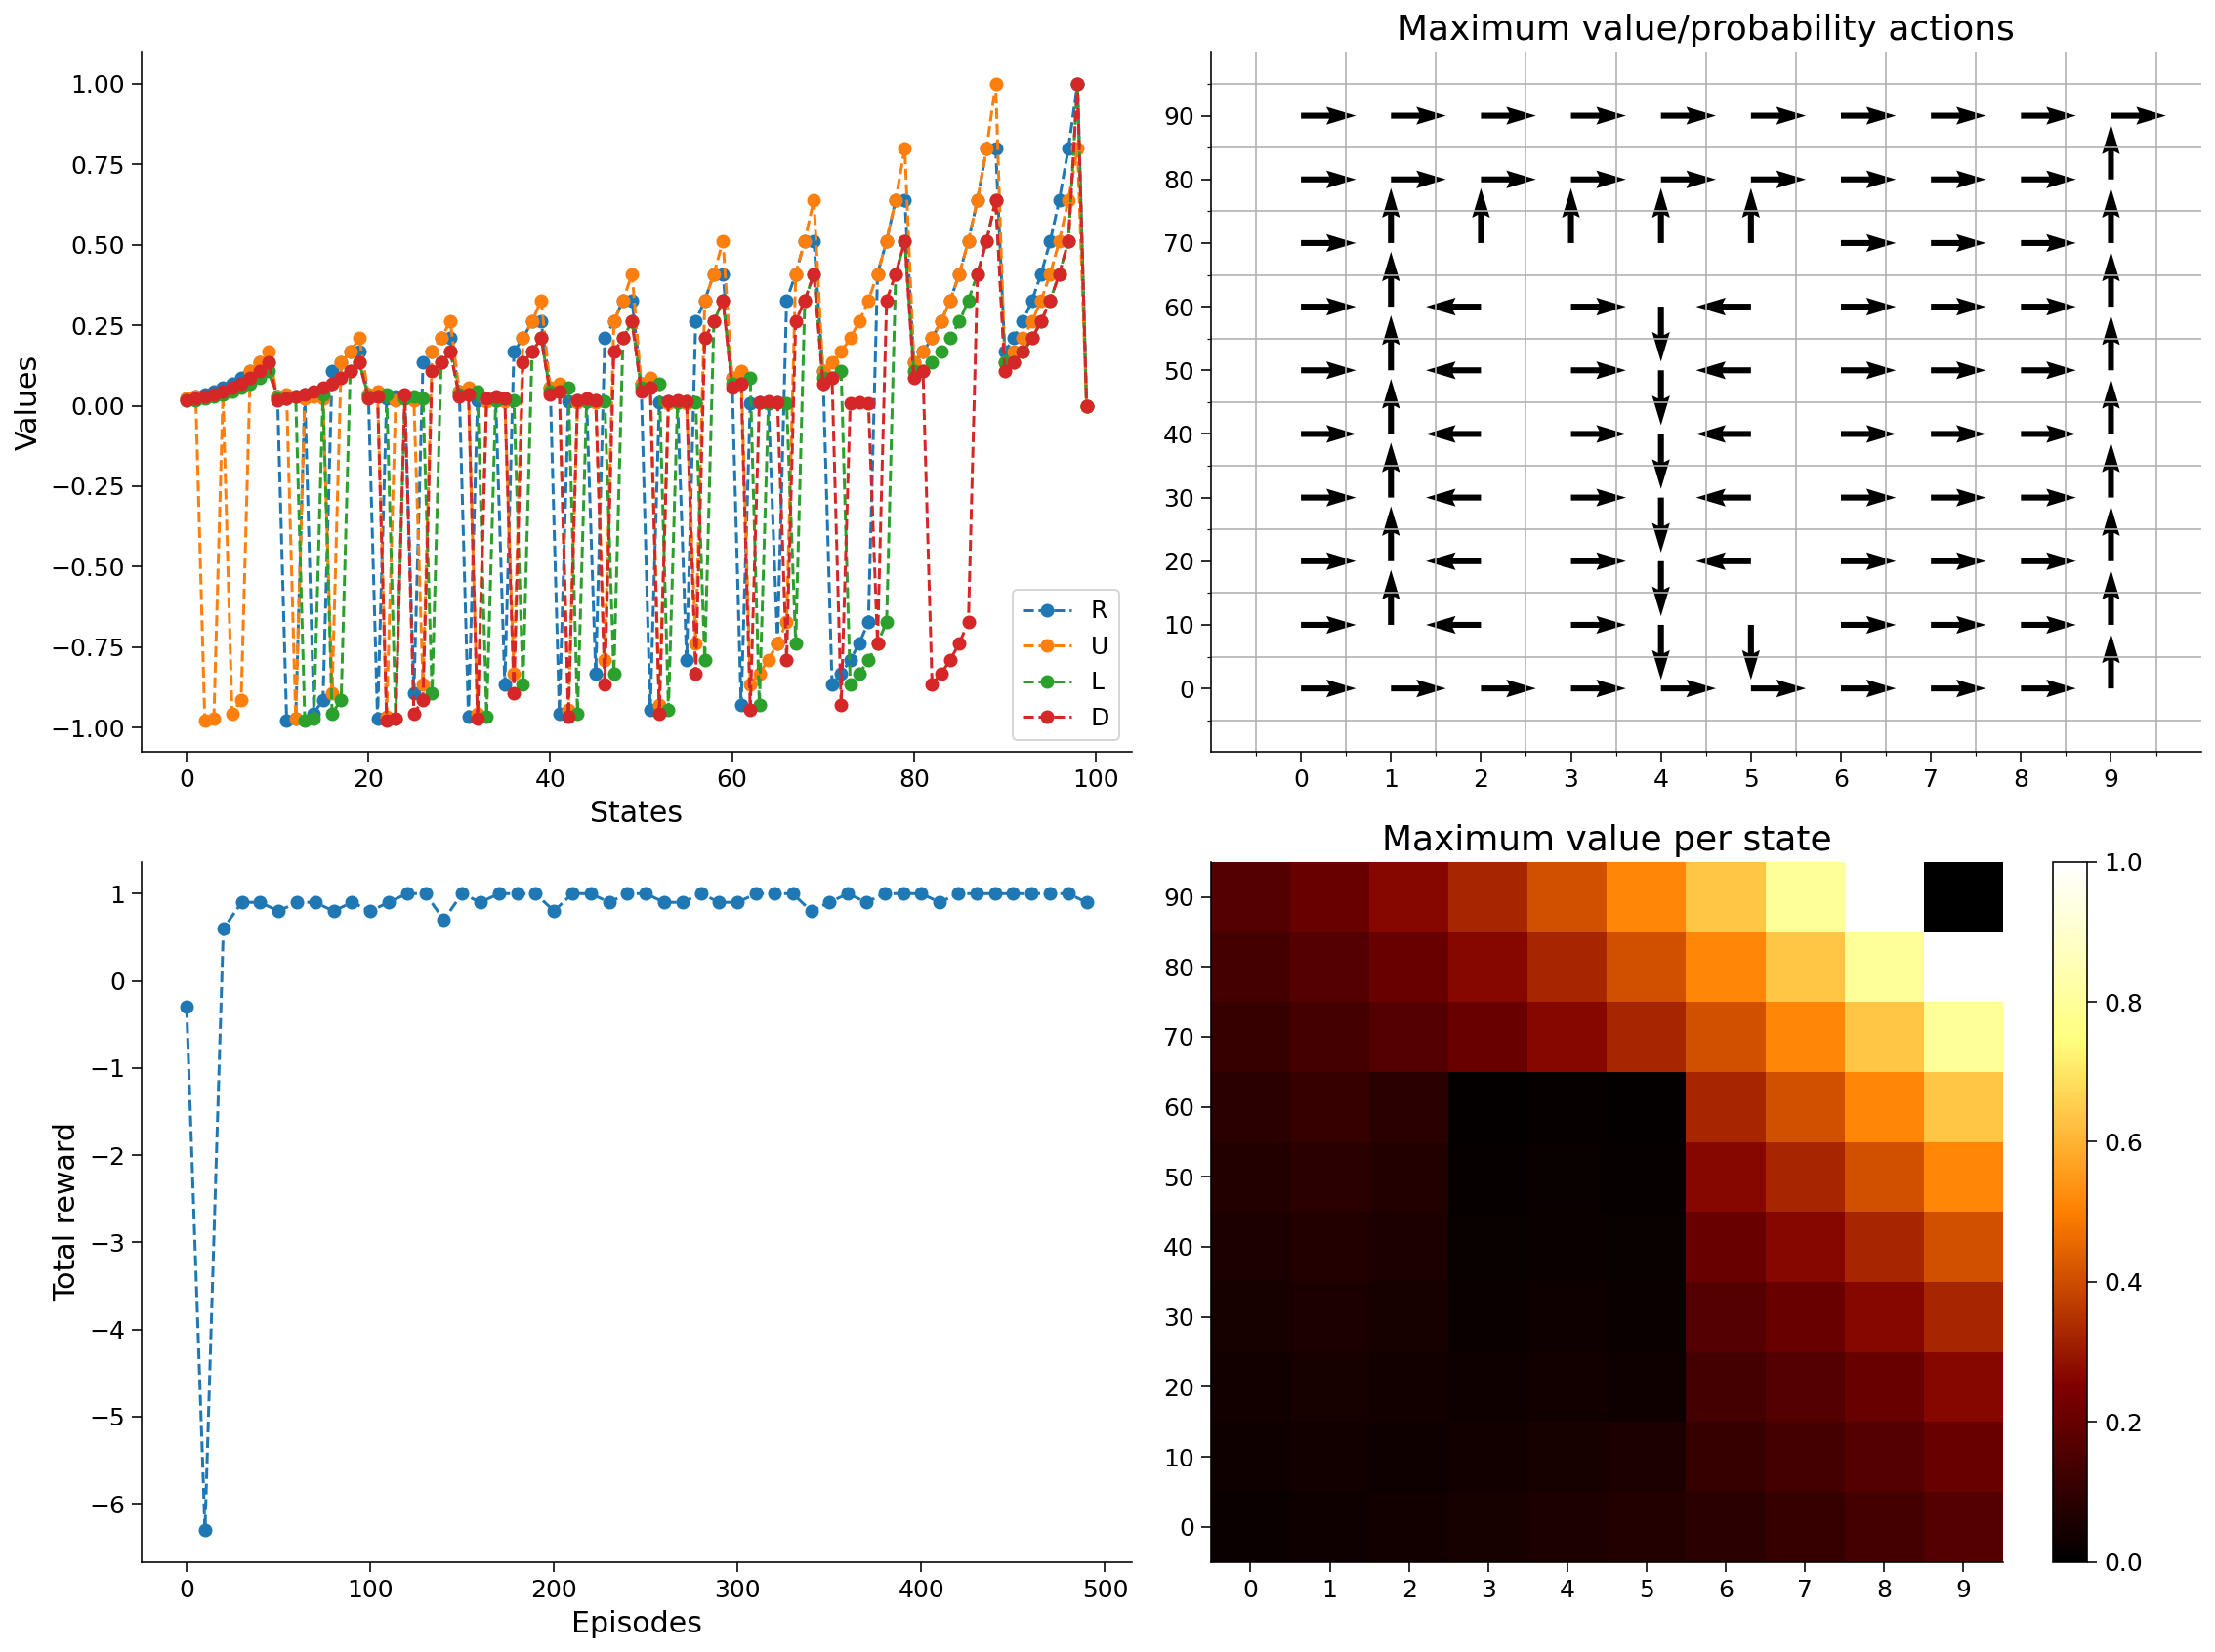

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
  'k': 10,  # number of Dyna-Q planning steps
}

# episodes/trials
n_episodes = 500
max_steps = 1000

# environment initialization
env = QuentinsWorld()

# solve Quentin's World using Dyna-Q
results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                            params, max_steps, n_episodes)
value, reward_sums, episode_steps = results

plot_performance(env, value, reward_sums)

Upon completion, we should see that our Dyna-Q agent is able to solve the task quite quickly, achieving a consistent positive reward after only a limited number of episodes (bottom left).

---
## Section 3: How much to plan?

Now that you implemented a Dyna-Q agent with $k=10$, we will try to understand the effect of planning on performance. How does changing the value of $k$ impact our agent's ability to learn?

The following code is similar to what we just ran, only this time we run several experiments over several different values of $k$ to see how their average performance compares. In particular, we will choose $k \in \{0, 1, 10, 100\}$. Pay special attention to the case where $k = 0$ which corresponds to no planning. This is, in effect, just regular Q-learning.

The following code will take a bit of time to complete. To speed things up, try lowering the number of experiments or the number of $k$ values to compare.

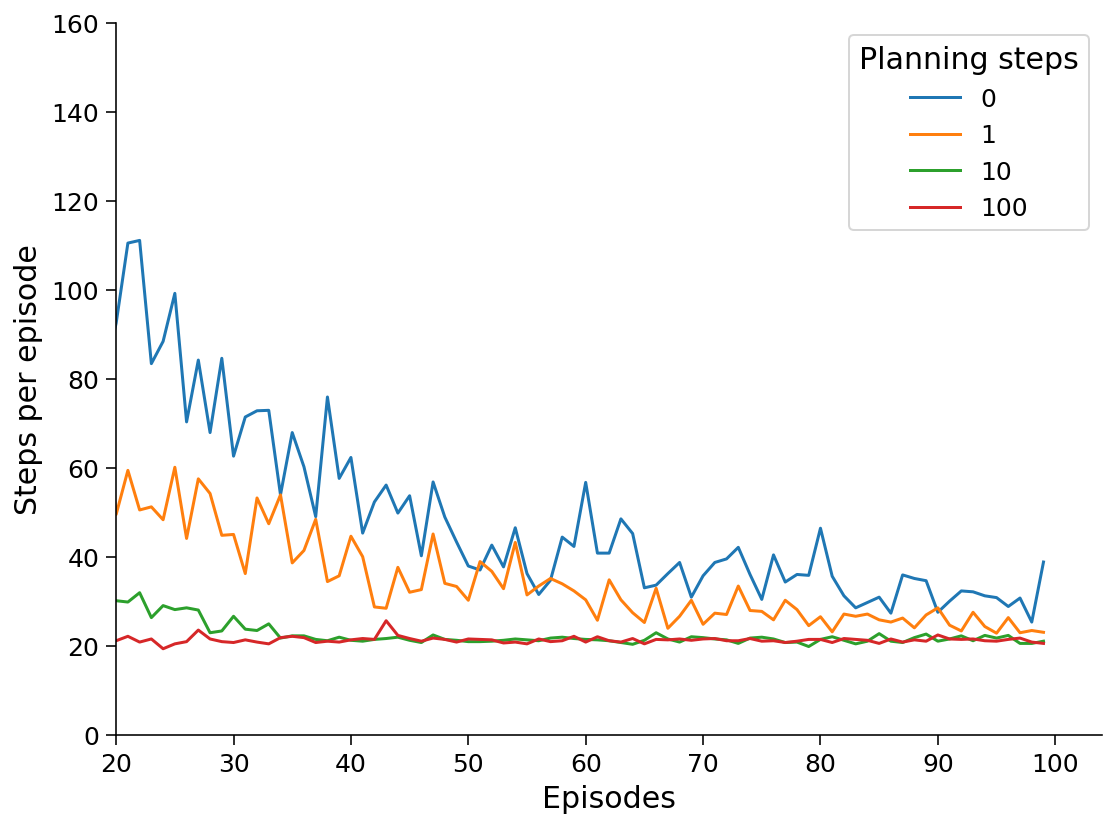

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_experiments = 10
n_episodes = 100
max_steps = 1000

# number of planning steps
planning_steps = np.array([0, 1, 10, 100])

# environment initialization
env = QuentinsWorld()

steps_per_episode = np.zeros((len(planning_steps), n_experiments, n_episodes))

for i, k in enumerate(planning_steps):
  params['k'] = k
  for experiment in range(n_experiments):
    results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                                params, max_steps, n_episodes)
    steps_per_episode[i, experiment] = results[2]

# Average across experiments
steps_per_episode = np.mean(steps_per_episode, axis=1)

# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episodes', ylabel='Steps per episode',
       xlim=[20, None], ylim=[0, 160])
ax.legend(planning_steps, loc='upper right', title="Planning steps");

After an initial warm-up phase of the first 20 episodes, we should see that the number of planning steps has a noticable impact on our agent's ability to rapidly solve the environment. We should also notice that after a certain value of $k$ our relative utility goes down, so it's important to balance a large enough value of $k$ that helps us learn quickly without wasting too much time in planning.

---
## Section 4: When the world changes...

In addition to speeding up learning about a new environment, planning can also help the agent to quickly incorporate new information about the environment into its policy. Thus, if the environment changes (e.g. the rules governing the transitions between states, or the rewards associated with each state/action), the agent doesn't need to experience that change *repeatedly* (as would be required in a Q-learning agent) in real experience. Instead, planning allows that change to be incorporated quickly into the agent's policy, without the need to experience the change more than once.

In this final section, we will again have our agents attempt to solve Quentin's World. However, after 200 episodes, a shortcut will appear in the environment.  We will test how a model-free agent using Q-learning and a Dyna-Q agent adapt to this change in the environment.

<img alt="QuentinsWorldShortcut" width="560" height="560" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial4_QuentinsWorldShortcut.png?raw=true">



The following code again looks similar to what we've run previously. Just as above we will have multiple values for $k$, with $k=0$ representing our Q-learning agent and $k=10$ for our Dyna-Q agent with 10 planning steps. The main difference is we now add in an indicator as to when the shortcut appears. In particular, we will run the agents for 400 episodes, with the shortcut appearing in the middle after episode #200.

When this shortcut appears we will also let each agent experience this change once i.e. we will evaluate the act of moving upwards when in the state that is below the now-open shortcut. After this single demonstration, the agents will continue on interacting in the environment.


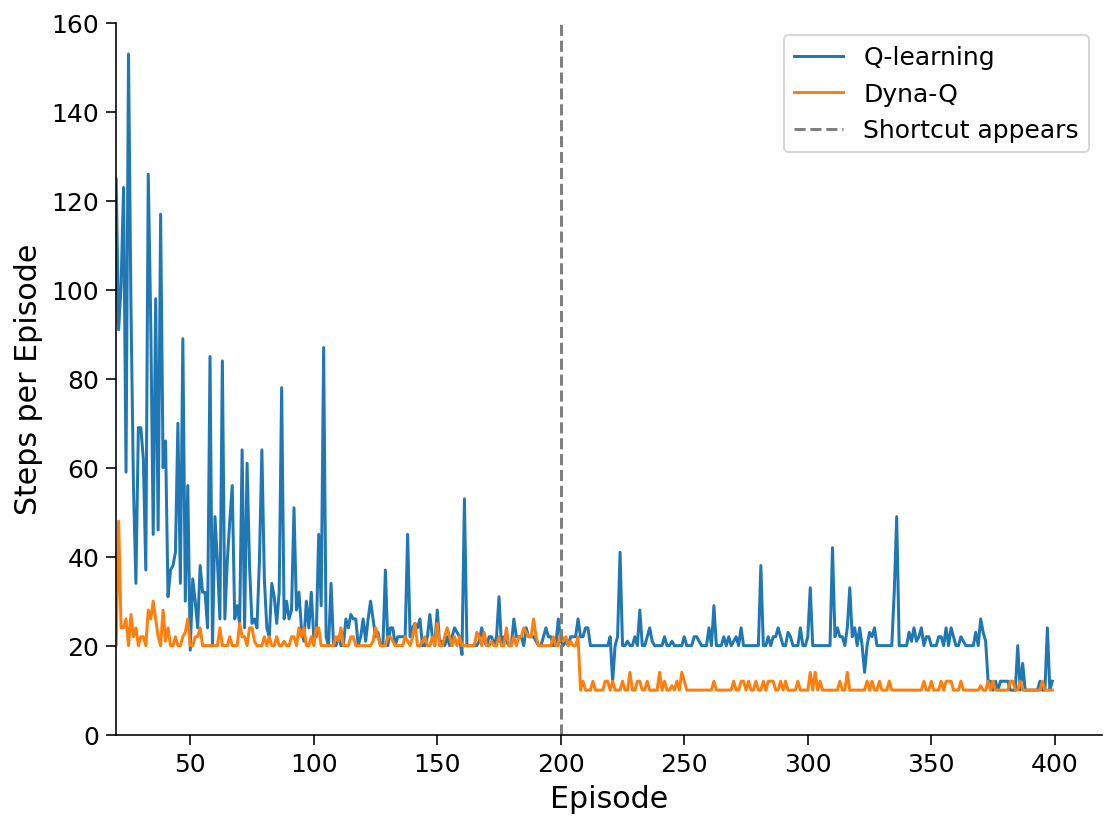

In [ ]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

# parameters needed by our policy and learning rule
params = {
  'epsilon': 0.05,  # epsilon-greedy policy
  'alpha': 0.5,  # learning rate
  'gamma': 0.8,  # temporal discount factor
}

# episodes/trials
n_episodes = 400
max_steps = 1000
shortcut_episode = 200  # when we introduce the shortcut

# number of planning steps
planning_steps = np.array([0, 10]) # Q-learning, Dyna-Q (k=10)

# environment initialization
steps_per_episode = np.zeros((len(planning_steps), n_episodes))

# Solve Quentin's World using Q-learning and Dyna-Q
for i, k in enumerate(planning_steps):
  env = QuentinsWorld()
  params['k'] = k
  results = learn_environment(env, dyna_q_model_update, dyna_q_planning,
                              params, max_steps, n_episodes,
                              shortcut_episode=shortcut_episode)
  steps_per_episode[i] = results[2]


# Plot results
fig, ax = plt.subplots()
ax.plot(steps_per_episode.T)
ax.set(xlabel='Episode', ylabel='Steps per Episode',
       xlim=[20,None], ylim=[0, 160])
ax.axvline(shortcut_episode, linestyle="--", color='gray', label="Shortcut appears")
ax.legend(('Q-learning', 'Dyna-Q', 'Shortcut appears'),
          loc='upper right');

If all went well, we should see the Dyna-Q agent having already achieved near optimal performance before the appearance of the shortcut and then immediately incorporating this new information to further improve. In this case, the Q-learning agent takes much longer to fully incorporate the new shortcut.

---
## Summary

In this notebook, you have learned about model-based reinforcement learning and implemented one of the simplest architectures of this type, Dyna-Q. Dyna-Q is very much like Q-learning, but instead of learning only from real experience, you also learn from **simulated** experience. This small difference, however, can have huge benefits! Planning *frees* the agent from the limitation of its own environment, and this in turn allows the agent to speed-up learning -- for instance, effectively incorporating environmental changes into one's policy.

Not surprisingly, model-based RL is an active area of research in machine learning. Some of the exciting topics in the frontier of the field involve (i) learning and representing a complex world model (i.e., beyond the tabular and deterministic case above), and (ii) what to simulate -- also known as search control -- (i.e., beyond the random selection of experiences implemented above).

The framework above has also been used in neuroscience to explain various phenomena such as planning, memory sampling, memory consolidation, and even dreaming!